<img src="logo_oncfm.png" alt="ONCFM" style="width: 400px;" align="left"/>

# MISSION

Vous êtes consultant Data Analyst dans une entreprise spécialisée dans la data. Votre entreprise a décroché une prestation en régie au sein de l’Organisation nationale de lutte contre le faux-monnayage (ONCFM).

Cette institution a pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Ils font donc appel à vous, spécialiste de la data, pour mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets. Et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent.

Le client souhaite que vous travailliez directement depuis ses locaux sous la responsabilité de Marie, responsable du projet d’analyse de données à l’ONCFM. Elle vous laissera une grande autonomie pendant votre mission, et vous demande simplement que vous lui présentiez vos résultats une fois la mission terminée. Elle souhaite voir quels sont les traitements et analyses que vous avez réalisés en amont, les différentes pistes explorées pour la construction de l’algorithme, ainsi que le modèle final retenu.

Après avoir lu en détail le cahier des charges, vous vous préparez à vous rendre à l’ONCFM pour prendre vos nouvelles fonctions. Vous notez tout de même un post-it qui se trouve sur le coin de votre bureau, laissé par un de vos collègues :

Lors de ma précédente mission, je me suis retrouvé avec un jeu de données comportant plein de valeurs manquantes, une vraie galère ! Mais j’ai eu de très bons résultats en utilisant une régression linéaire pour combler ces dernières. Ça te servira peut-être pour ta prochaine mission, qui sait ?

## Donnés complémentaires
Nous disposons actuellement de six informations géométriques sur un billet :<br>
● length : la longueur du billet (en mm) ;<br>
● height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm) ;<br>
● height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;<br>
● margin_up : la marge entre le bord supérieur du billet et l'image de
celui-ci (en mm) ;<br>
● margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm) ;<br>
● diagonal : la diagonale du billet (en mm).<br>

# I. LES DONNEES

## Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # to custom legend
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing, neighbors, metrics
from sklearn.metrics import *
from sklearn.impute import KNNImputer 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression 

#from sklearn import decomposition 
from sklearn.cluster import KMeans
from fanalysis import pca

# Evaluation du modele
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_curve
from sklearn.model_selection import learning_curve, cross_val_score
from yellowbrick.model_selection import LearningCurve

import statsmodels.api as sm

import scipy.stats as stats
#from scipy.stats import pearsonr
#import math # pour le calcul des mean_squared_error

# Tests statistiques
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.compat import lzip
from numpy import sqrt as  sqrt #racine carré
from statsmodels.stats.api import  het_breuschpagan

from sklearn.pipeline import make_pipeline

## Import des données

In [2]:
banknotes = pd.read_csv("files/billets.csv", sep=";")
banknotes

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


Je ne conserve que 150 billets pour tester la prédiction sur un petit échantillon.

In [3]:
banknotes = banknotes.sample(n=150,random_state=42)
banknotes

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1116,False,172.26,103.90,104.12,4.99,3.42,111.27
1368,False,171.65,104.32,104.38,5.65,3.24,112.30
422,True,171.53,103.53,103.63,4.04,2.96,112.76
413,True,172.30,103.66,103.50,NaN,3.16,112.95
451,True,172.17,103.79,103.54,4.07,2.78,113.03
...,...,...,...,...,...,...,...
1312,False,171.92,104.37,104.05,4.95,3.04,110.61
694,True,171.49,103.77,103.60,4.01,3.09,112.95
1001,False,171.92,103.86,104.30,4.96,3.13,111.29
322,True,171.75,104.13,103.91,4.24,2.97,113.33


In [4]:
banknotes.is_genuine.value_counts()

True     99
False    51
Name: is_genuine, dtype: int64

## Fonctions

In [5]:
def plot_scatter (X):
    '''
    Fonction pour afficher les histogrammes des variables quantitatives
    Prend X en entrée
    '''
    fig = plt.figure(figsize=(20, 10))

    for i in range(X.shape[1]-1): # all the columns but the last one       
        ax = fig.add_subplot(2,3, (i+1))
        #graph=sns.FacetGrid(data=X,hue="is_genuine")
        sns.scatterplot(x=X.iloc[:, i], y=X.iloc[:, -1],hue=X.is_genuine)#, hue="is_genuine")

            #ax.plot_reg_lin( X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none') # toutes les valeurs par variable
        plt.xlabel(banknotes_df.columns[i],labelpad=10)
        plt.ylabel("margin_low", labelpad=10)
        #plt.set_title(f"Régression linéaire entre margin_low et {banknotes_df.columns[i]}", fontsize=14,pad=40 )
        

In [6]:
def plot_boxes (df):
    '''
    Plot in a boxplot graph the distribution of each variable.
    
    Parameter : Dataframe
    '''
    fig = plt.figure(figsize=(20, 20))
    meanprops = {'marker':'o', 'markeredgecolor':'black', 'markerfacecolor':'firebrick'}
    for i in range(df.shape[1]): # de 1 à nombre de colonnes -> nombre de variables
        if df.columns[i]!="is_genuine":
            ax = fig.add_subplot(3,2, i)
            ax = sns.boxplot(x=df.iloc[:, i], y="is_genuine", data=df, linewidth=2, fliersize=1.5, orient="h",meanprops=meanprops,showmeans=True)
            
            plt.xlabel(df.columns[i], fontsize = 10, labelpad=5)
            plt.ylabel("is_genuine", fontsize = 10, labelpad=5)
            plt.title("Distribution " + df.columns[i] + " vs. is_genuine", fontsize = 20,loc='center', pad=10)

In [7]:
def error_histogram(y_df,y_pred):
    '''
    Plotting the histogram of my errors by calculating the absolute value between y and y prediction (average absolute error).
    Parameters :
        - y as dataframe
        - y predicted as array
    Return : 
        Histogram of errors
    '''
    plt.hist(np.abs(y_df-y_pred), bins=50)
    plt.show()

In [8]:
def residual_histogram (stats_mod_results):
    '''
    Plotting the histogram of the residual errors (from statsmodel) and the gaussian curve
    Parameters :
        - stats_mod_results which gives the residuals
    Return : 
        Histogram of residuals
    '''

    plt.hist(stats_mod_results, density=True)
    plt.xlabel('Résidus')
    plt.title('Histogramme des résidus')

    #Tracé de la courbe gaussienne
    mu = np.mean(stats_mod_results)
    sigma = np.std(stats_mod_results, ddof=1)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))
    plt.show()


In [9]:
def shapiro_test(model):
    '''
    Teste la normalité des résidus
    L’objectif est de s’assurer que les résidus suivent une loi normale afin de ne pas affirmer qu’il existe une différence de moyenne entre les groupes qui serait causée par le hasard -> le but étant qu'on se trompe beaucoup de peu et peu de beaucoup, plutôt que l'inverse.

    On utilise le test de Shapiro-Wilk pour tester la normalité des résidus où :

    Hypothèses :

        - H0 : Les résidus suivent une loi normale si p-value > 0.05
        - H1 : Les résidus ne suivent pas une loi normale si p-value < 0.05
        - Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

    Si p-value est inférieure à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.
    '''
    
    shapiro_result=shapiro(model.resid)

    if shapiro_result[1]>0.05:
        return print(f"Les résidus suivent une loi normale, p-value valant {shapiro_result[1]:.2f}.")
    else:
        return print(f"Les résidus ne suivent pas une loi normale, p-value valant {shapiro_result[1]:.2f}.")

In [10]:
def durbin_watson_test(model) : 
    '''
    Teste l'indépendance des résidus
    Le test de Durbin-Watson est un test statistique destiné à tester l'autocorrélation des résidus dans un modèle de régression linéaire.
    La statistique DW prend ses valeurs entre 0 (auto-corrélation linéaire positive) et 4 (auto-corrélation linéaire négative). <br>

    Hypothèses :

        - H0 : Variables indépendantes si le résultat vaut dans les 2,<br>
        - H1 : Variables non indépendantes si le résultat s'écarte de 2,<br>

    L'hypothèse nulle est retenue si la statistique a une valeur proche de 2 (pas d'auto-corrélation linéaire). On va prendre un intervalle compris entre 1.8 et 2.2.<br>
    '''
    
    dw_result=durbin_watson(model.resid)

    if 1.8<dw_result<2.2:
        return print(f"Les résidus sont indépendants, p-value valant {dw_result:.2f}.")
    else:
        return print(f"Les résidus ne sont pas indépendants p-value valant {dw_result:.2f}.")

In [11]:
def breuschpagan_test(model) :
    '''
    Teste l'homogénitié des résidus
    Permet de vérifier que la variance des résidus est constante (cas d'homoscédasticité).
    Cet test renvoie une p-value qui interroge la variance des résidus. Si la p-value est inférieure à 0,05, on doit rejeter la régression comme présentant de l'hétéroscédasticité.<br>
    On va cette fois-ci raisonner sur les résidus standardisés, la racine carrée des résidus standards.<br>


    On notera qu'on ne donne pas à avaler les résidus standardisés (la racine carrée des résidus standards) à cette fonction car elle se charge de mener les bons calculs. Il faut le faire si on représenta graphiquement la variance.<br>

    model.exog correspond à une array qui regroupe les indices des résidus les plus susceptibles d'induire une hétéroscédasticité.

    Hypothèses :

        - H0 : Variables homogènes si p-value > alpha,<br>
        - H1 : Variables non homogènes si p-value < alpha,<br>
        - Seuil de risque alpha (p-value) = 0.05, soit un risque de 5 % de conclure à tort qu'une différence existe.

    Si p-value est inférieur à 0.05, on rejette l'hypothèse nulle avec un risque d'erreur égal à la p-value.
    '''
    
    lm, lm_pvalue, fvalue, pvalue = het_breuschpagan(model.resid, model.model.exog)
    if pvalue<0.05:
        return print(f"Les résidus ne sont pas homogènes, p-value valant {pvalue:.2f}.")
    else:
        return print(f"Les résidus sont homogènes, p-value valant {pvalue:.2f}.")

In [12]:
def pred_inf_10_percent(y_true_df, y_predicted):
    '''
    Return the percentage of prediction with an error inferior to 10%
    Parameters :
        - y_true : copy of the y_test as dataframe
        - y_predicted : the prediction to compare
    '''
    
    if 'margin_low_pred' not in y_true_df.columns :
        y_true_df.insert(1,'margin_low_pred',y_predicted)
    # Calculation of the difference, in absolute value, between the predicted value and the true value
    y_true_df["Ecart entre réel et prédiction"]=abs(y_true_df.margin_low - y_true_df.margin_low_pred)
    # Percentage of previous value
    y_true_df["% écart"]=abs((y_true_df.margin_low - y_true_df.margin_low_pred)/y_true_df.margin_low)*100
    
    # Je discrétise mes erreurs via la méthode cut() qui permet de découper une variable numérique en tranche.
    y_true_df["% d'écart cut"] = pd.cut(y_true_df["% écart"], bins = [0,10,50], labels=['moins de 10%',"au-delà de 10%"],include_lowest=True)
    
    # Calculation of the percentage of error under 10%
    precision=(y_true_df[y_true_df["% d'écart cut"]=="moins de 10%"].shape[0])/y_true_df.shape[0]
    return precision

In [13]:
def display_scores(y_true,y_pred):
    '''
    Return score : mean_squared_error, mean_squared_log_error, r2_score, mean_absolute_error, median_absolute_error
    Parameters : 
        - y_true
        - y_pred
    Returns the different scores
    '''
    
    rmse =  mean_squared_error(y_true, y_pred,squared=False) #on peut multiplier par 0.3 pour avoir un résultat en mètre
    rmsle = mean_squared_log_error(y_true, y_pred,squared=False) # La RMSE ne se comporte pas très bien quand les étiquettes peuvent prendre des valeurs qui s'étalent sur plusieurs ordres de grandeur. On utilise alors le log.
    r2 = r2_score(y_true, y_pred)
    meanae = mean_absolute_error(y_true,y_pred)
    medae = median_absolute_error(y_true,y_pred)

    # Affichage des valeurs
    print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
    print("Racine carrée logarithmique de l'erreur quadratique moyenne : ", rmsle)
    print("Moyenne absolue des erreurs :", meanae)
    print("Médiane absolue des erreurs :", medae)
    print(f"""Le coefficient de détermination (Score R² de précision) vaut: {r2:.2f}
    => Le modèle décrit {r2:.2%} des variations de la marge inférieure d'un billet.""")
    

In [14]:
def plot_crosstab(matrix, title):
    '''
    plot a crosstab dataframe
    Parameters :
        - the matrix (dataframe or confusion_matric)
        - The title of the graph
    '''
    plt.figure(figsize=(10,5))
    sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="Blues", fmt='g')
    plt.title(title, pad=20, fontsize=15)
    plt.ylabel('Valeurs réelles', fontsize=15)
    plt.xlabel('Valeurs prédites', fontsize=15)
    plt.show()


In [15]:
def draw_circle():
    '''
    Tracé d'un cercle de diamètre 1
    '''
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(np.cos(theta), np.sin(theta), color='grey', ls='--', lw=2 )  # Add a unit circle for scale

In [16]:
def display_factorial_planes(X_projected, n_comp,  axis_ranks, alpha=1, pca=None,illustrative_var=None, labels=None, title_type=None,title_nb_of_indiv=None, method=None):
    '''
    Factorial planes to visualize the distribution of individuals or centroids.
    Parameters :
        - X_projected as numpy array
        - axis_ranks as number of plan
        - labels : legend on the dots
        - method = clustering method (CAH ou Kmeans) 
    '''
    for d1,d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure       
            fig = plt.figure(figsize=(20,20))
            plt.grid(visible=None)
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha, s=200)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value, s=200)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    if not str(labels[i]).isdigit():
                        plt.text(x, y, labels[i][:8],# je raccourcis le nom du pays
                              fontsize='12', ha='center',va='center') 
                    else:
                        plt.text(x, y, labels[i],
                              fontsize='12', ha='center',va='center') 
            # détermination des limites du graphique - je fixe les limites à la main pour avoir la même échelle entre la projection des centroïdes et des individus
            
            #boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            #plt.xlim([-boundary,boundary])
            #plt.ylim([-boundary,boundary])
            lim=4*1.25
            plt.xlim([-lim,lim])
            plt.ylim([-lim,lim])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')
            
            # appel de la fonction de tracé de cercle pour observer les variables qui sont dedans et en dehors.
            draw_circle()
            
            # nom des axes, avec le pourcentage d'inertie expliqué quand on a la variable pca
            if pca is None:
                plt.xlabel('F1')
                plt.ylabel('F2')
            else:
                plt.xlabel(f'F{d1+1} ({round(pca.eig_[1][d1],2)}%)')
                plt.ylabel(f'F{d2+1} ({round(pca.eig_[2][d2]-pca.eig_[1][d1],2)}%)')
            
            if method is None:
                plt.title(f"Projection des {title_nb_of_indiv} {title_type} sur le 1er plan factoriel")         
            else:
                plt.title(f"Projection des {title_nb_of_indiv} {title_type} sur le 1er plan factoriel - Méthode {method}") 
                
            plt.legend(loc="upper right",title="Clusters", title_fontsize=16, fontsize=12)
            plt.show(block=False)

## Analyse de la qualité des données

### Types de données

In [17]:
banknotes.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

<u>**Observation**</u><br>
Aucune anomalie de type détectée. 

### Détection d'outliers

On commence par une analyse visuelle

In [18]:
banknotes.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,150.000000,150.000000,150.000000,146.000000,150.000000,150.000000
mean,171.934667,103.985267,103.922200,4.494110,3.136533,112.679533
std,0.303544,0.290777,0.332364,0.695112,0.243313,0.852016
min,171.130000,103.250000,102.910000,3.250000,2.650000,110.220000
25%,171.730000,103.770000,103.670000,4.025000,2.970000,112.055000
50%,171.920000,103.980000,103.925000,4.360000,3.130000,112.955000
75%,172.150000,104.200000,104.157500,4.942500,3.297500,113.330000
max,172.760000,104.850000,104.870000,6.650000,3.770000,114.440000


### Détection des valeurs nulles

In [19]:
banknotes.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      4
margin_up       0
length          0
dtype: int64

<u>**Observation**</u><br>
- Le jeu de données est composé de 7 variables : 
    - 6 variables numériques 
    - 1 booléenne qui indique si le billet est vrai ou faux.
- A priori il n'y a pas d'outliers dans les données. On observe un max un peu élevé sur margin_low.<br>
- 37 valeurs nulles sont répertoriées et ne concernent que la variable margin_low

L'analyse descriptive des données va nous donner plus de détails.
____________

# II. ANALYSE DESCRIPTIVE DES DONNEES

## Corrélation
Méthode Spearman sur des variables quantitatives uniquement.

In [20]:
banknotes.drop(columns="is_genuine").corr().style.background_gradient(cmap='coolwarm').format(precision = 2)

,diagonal,height_left,height_right,margin_low,margin_up,length
diagonal,1.00,0.01,-0.05,-0.12,-0.07,0.09
height_left,0.01,1.00,0.16,0.28,0.27,-0.34
height_right,-0.05,0.16,1.00,0.50,0.40,-0.45
margin_low,-0.12,0.28,0.50,1.00,0.47,-0.60
margin_up,-0.07,0.27,0.40,0.47,1.00,-0.51
length,0.09,-0.34,-0.45,-0.60,-0.51,1.00


Je passe les valeurs en absolues pour mieux voir les corrélations, qu'elles soient positives ou négatives.

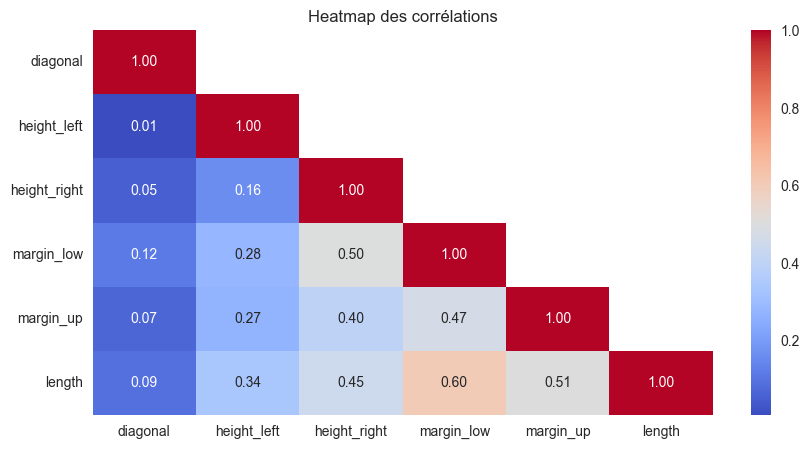

In [21]:
plt.figure(figsize=(10,5))
mask = np.triu(np.ones_like(banknotes.drop(columns="is_genuine").corr().abs()),k=1)
sns.heatmap(banknotes.drop(columns="is_genuine").corr().abs(), mask=mask,cmap='coolwarm',fmt = ".2f", annot=True,annot_kws = {'size':10})
plt.title('Heatmap des corrélations')
plt.show()

<u>**Observation**</u><br>
*length* et *margin_low* sont les 2 variables les plus corrélées (négativement -0,67) : + la longueur sera élevée, plus la marge basse sera petite, ou inversement.<br>
*length* et *margin_up* sont également anticorrélés (-0.52).
____________

## Distribution 

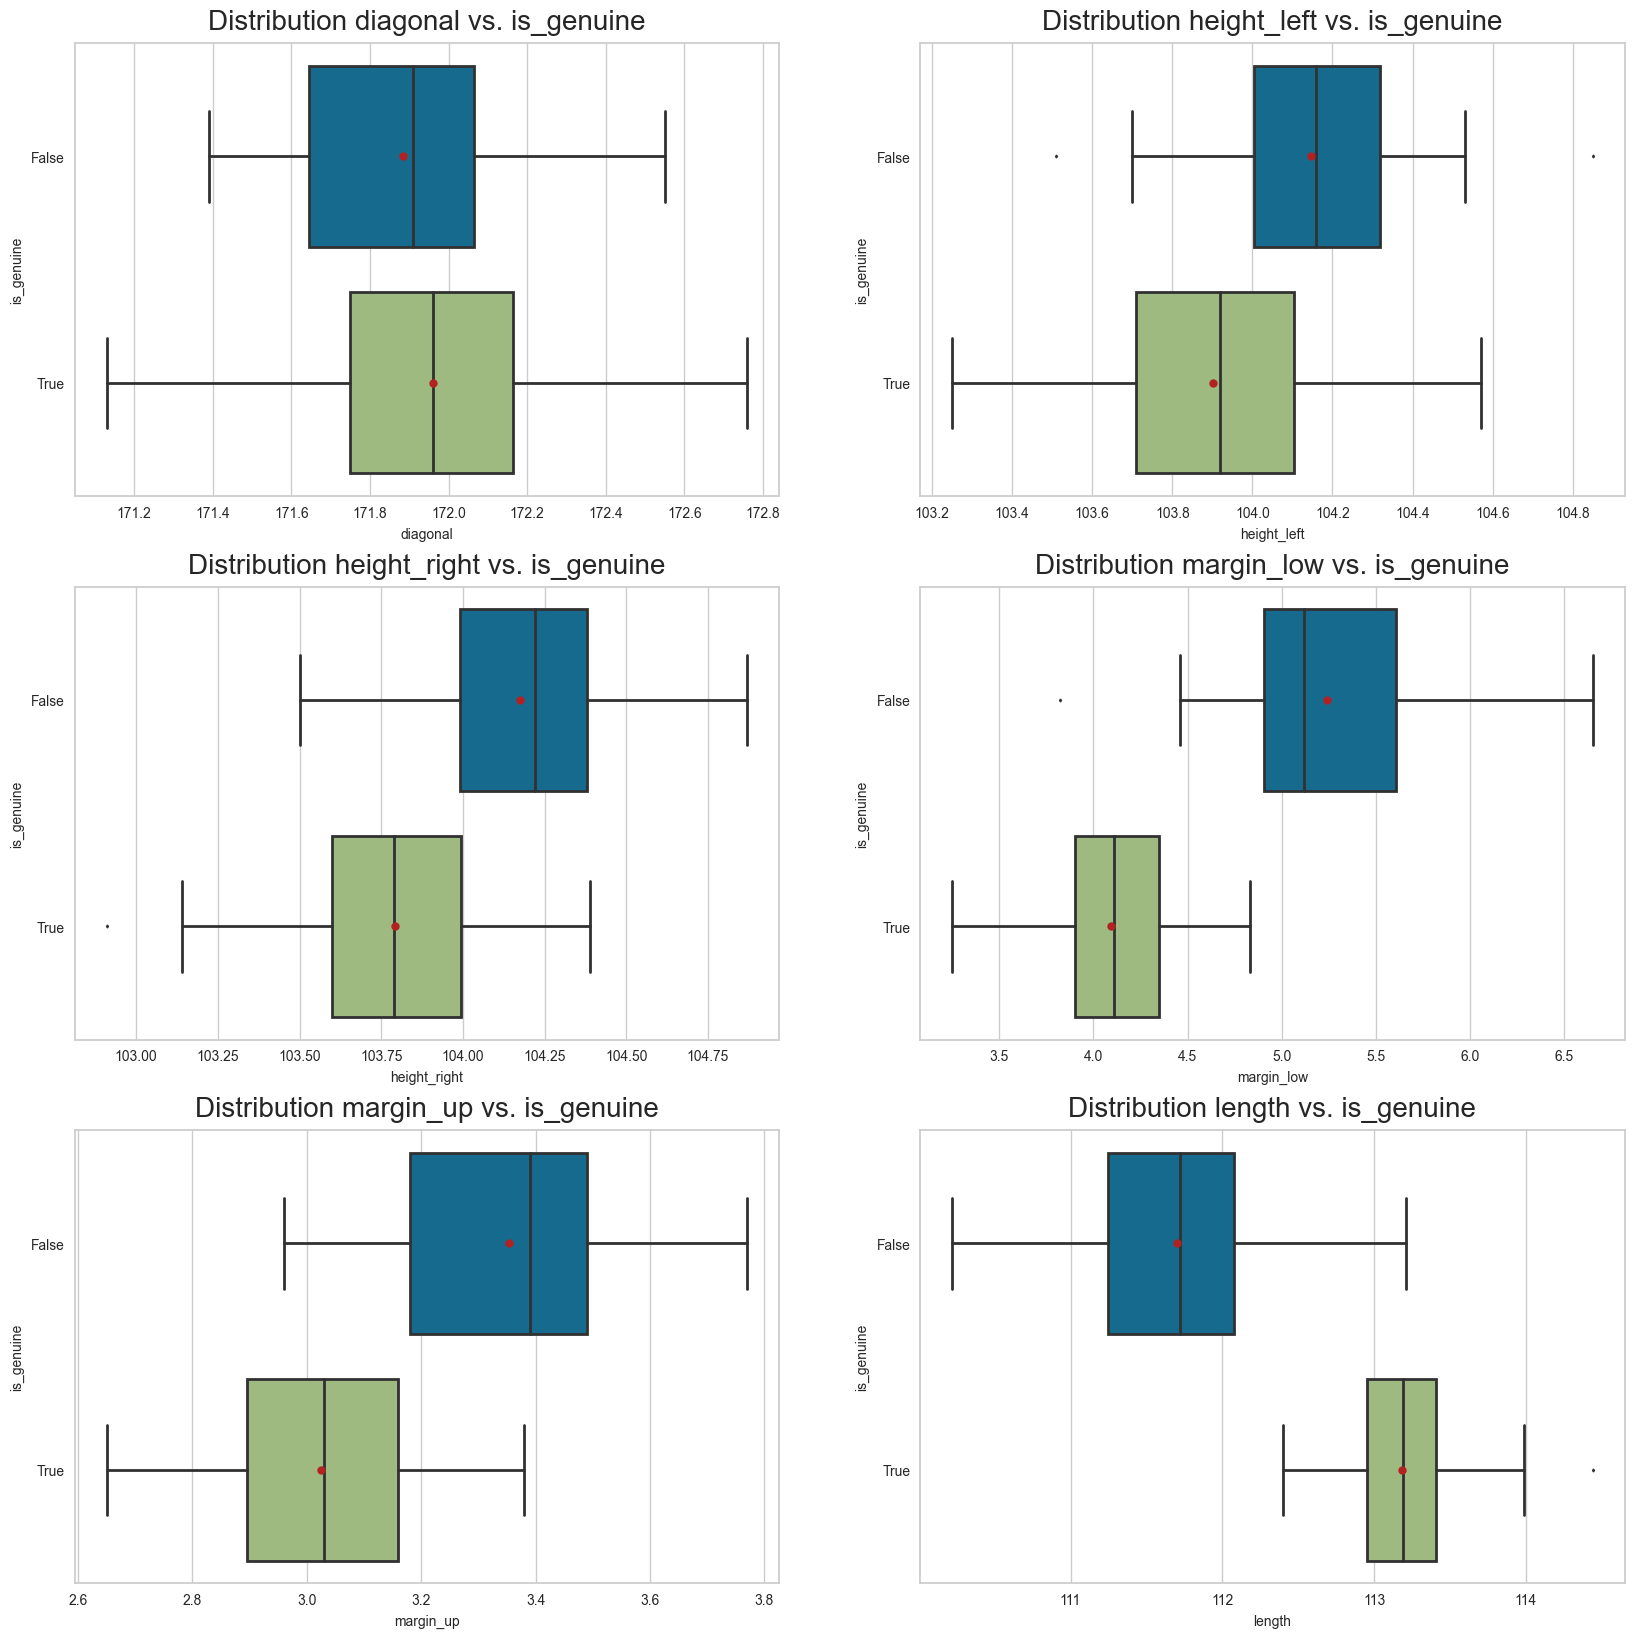

In [22]:
plot_boxes(banknotes)

<u>**Observation**</u><br>
Il y a peu d'outliers, et ils restent proches des extrémités : on peut considérer qu'ils ne sont pas gênants et les conserver pour l'analyse et les prédictions.

Les variables *margin_low* et *lengh* permettent le mieux distinguer les vrais billets des faux, ce qui confirme l'observation faite à partir de la matrice de corrélation.<br>
La *diagonale* et les hauteurs sont moins pertinentes.
_________

## Distributions bivariées

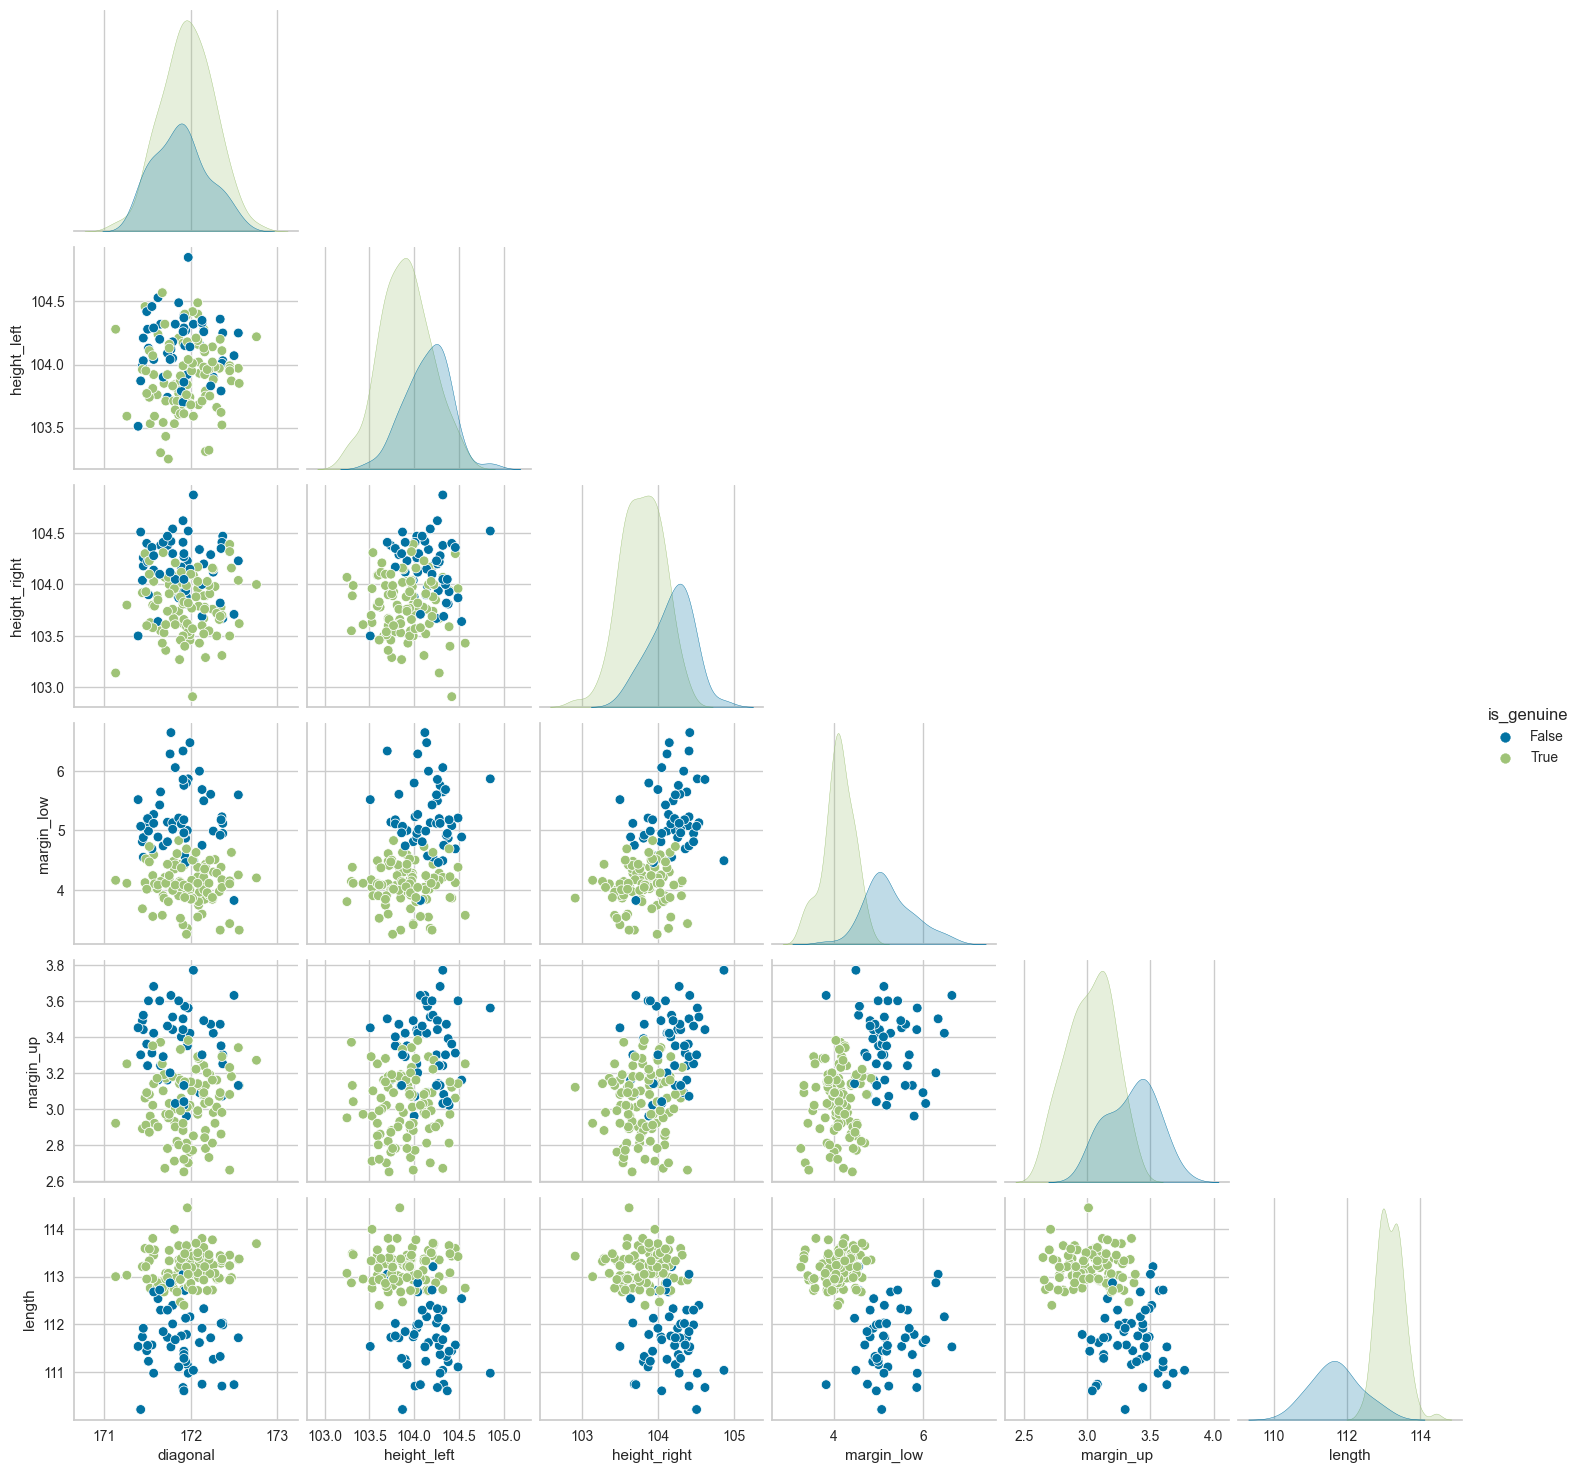

In [23]:
sns.pairplot(banknotes , hue='is_genuine', corner=True)
plt.show()

<u>**Observation**</u><br>
La visualisation confirme les observations faites sur les boites à moustaches :<br>
- Les billets authentiques sont plus longs et ont une marge entre le bord inférieur du billet et son image plus restreinte que les faux billets.<br>
- Les hauteurs sont peu discriminantes.
____________________

## Répartition vrais/faux billets

In [24]:
distribution_is_genuine = banknotes.groupby("is_genuine").agg(number_of_banknotes=("is_genuine","count")).reset_index()
distribution_is_genuine

,is_genuine,number_of_banknotes
0,False,51
1,True,99


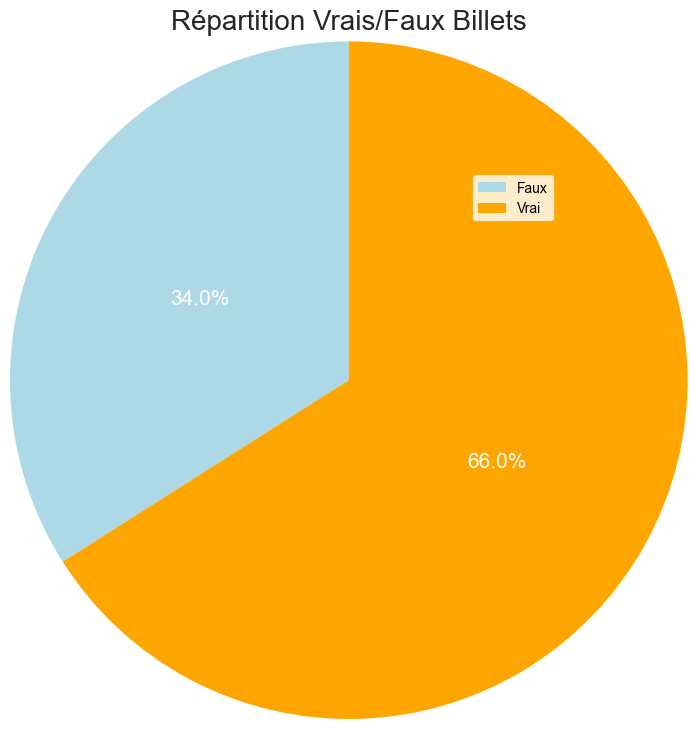

In [25]:
distribution=distribution_is_genuine.number_of_banknotes

colors = ['lightblue',"orange"]
labels = "Faux","Vrai"

#preparing the graph
plt.pie(distribution,colors=colors,labeldistance=0.5,startangle = 90, radius=2, pctdistance=0.5,autopct='%1.1f%%', textprops={'color':"w", "size":15})


#Legends and title
plt.title("Répartition Vrais/Faux Billets", pad=100, loc='center', fontsize=20)
plt.legend(labels, loc="best",labelcolor='black', frameon=True,)

plt.show()

# III. REMPLACEMENT DES VALEURS NULLES

Je réaffiche les valeurs nulles

In [26]:
banknotes.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      4
margin_up       0
length          0
dtype: int64

Je réorganise mes colonnes pour avoir la variable à prédire en dernier

In [27]:
# shift column 'margin_low' to last position
last_column = banknotes.pop('margin_low')
  
# insert column using insert(position,column_name, column) function
banknotes.insert(banknotes.columns.size, 'margin_low', last_column)

In [28]:
banknotes

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
1116,False,172.26,103.90,104.12,3.42,111.27,4.99
1368,False,171.65,104.32,104.38,3.24,112.30,5.65
422,True,171.53,103.53,103.63,2.96,112.76,4.04
413,True,172.30,103.66,103.50,3.16,112.95,NaN
451,True,172.17,103.79,103.54,2.78,113.03,4.07
...,...,...,...,...,...,...,...
1312,False,171.92,104.37,104.05,3.04,110.61,4.95
694,True,171.49,103.77,103.60,3.09,112.95,4.01
1001,False,171.92,103.86,104.30,3.13,111.29,4.96
322,True,171.75,104.13,103.91,2.97,113.33,4.24


Je sauvegarde mes billets ayant des valeurs nulles dans un dataframe dédié

In [29]:
null_notes_mask = banknotes[banknotes.margin_low.isna()]
null_notes_mask

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
413,True,172.30,103.66,103.50,3.16,112.95,NaN
654,True,171.97,103.69,103.54,2.70,112.79,NaN
798,True,171.96,103.84,103.62,3.01,114.44,NaN
481,True,171.81,103.53,103.96,2.71,113.99,NaN


In [30]:
null_notes_mask.shape

(4, 7)

## Régression linéaire multiple
Je conserve toutes mes données explicatives sauf la future valeur à prédire (is_genuine)

### Préparation des données pour le modèle

Je supprime les valeurs NA pour pouvoir ensuite faire une régression linéaire pour imputer les valeurs manquantes

In [31]:
banknotes_df=banknotes.copy()
banknotes_df.dropna(inplace=True)

In [32]:
X = banknotes_df[banknotes_df.columns.difference(["is_genuine","margin_low"],sort=False)]#.copy() # sort = False to keep the columns in the initial order
X

,diagonal,height_left,height_right,margin_up,length
1116,172.26,103.90,104.12,3.42,111.27
1368,171.65,104.32,104.38,3.24,112.30
422,171.53,103.53,103.63,2.96,112.76
451,172.17,103.79,103.54,2.78,113.03
861,171.86,104.21,103.74,2.90,113.65
...,...,...,...,...,...
1312,171.92,104.37,104.05,3.04,110.61
694,171.49,103.77,103.60,3.09,112.95
1001,171.92,103.86,104.30,3.13,111.29
322,171.75,104.13,103.91,2.97,113.33


In [33]:
y = banknotes_df[["margin_low"]]
y

,margin_low
1116,4.99
1368,5.65
422,4.04
451,4.07
861,4.43
...,...
1312,4.95
694,4.01
1001,4.96
322,4.24


Je vais encoder la variable booléenne afin d'avoir une variable continue pour ma régression avec :<br>
 - False = 0
 - True = 1
 
Il n'est pas nécessaire d'utiliser une méthode d'encoding (One hot encoding ou get_dummies) car nous avons affaire à une variable booléenne qui ne prend que 2 valeurs.<br>
**Je multiplie mon dataframe par 1 pour avoir l'équivalent de la valeur booléenne en chiffre.**

In [34]:
X=X*1
X.dtypes

diagonal        float64
height_left     float64
height_right    float64
margin_up       float64
length          float64
dtype: object

In [35]:
X

,diagonal,height_left,height_right,margin_up,length
1116,172.26,103.90,104.12,3.42,111.27
1368,171.65,104.32,104.38,3.24,112.30
422,171.53,103.53,103.63,2.96,112.76
451,172.17,103.79,103.54,2.78,113.03
861,171.86,104.21,103.74,2.90,113.65
...,...,...,...,...,...
1312,171.92,104.37,104.05,3.04,110.61
694,171.49,103.77,103.60,3.09,112.95
1001,171.92,103.86,104.30,3.13,111.29
322,171.75,104.13,103.91,2.97,113.33


On visualise la distribution de chaque variable explicative par rapport à la variable à prédire

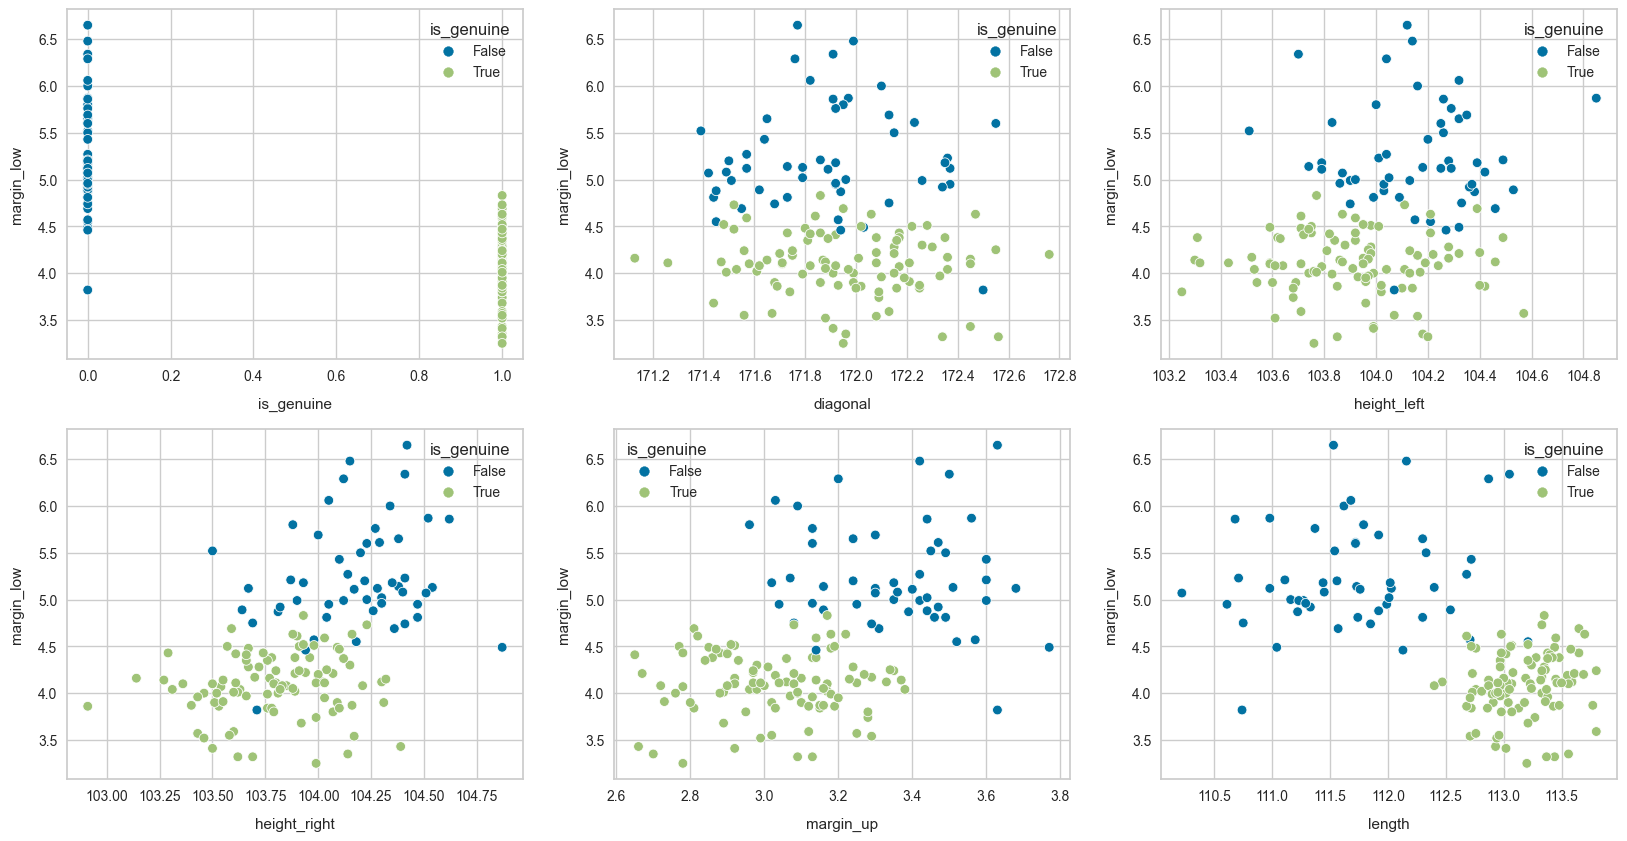

In [36]:
plot_scatter(banknotes_df)

Nos variables ont la même unité, mais les variables liées à la marge ont de bien plus petites valeurs que les dimensions du billet. Je vais donc centrer et réduire les données pour que les + grandes valeurs ne dominent pas complètement les marges.<br>

In [37]:
#std_scale = preprocessing.StandardScaler().fit(X)

### Echantillonnage

On a 6 variables explicatives et 1 à prédire.<br>
Je sépare le jeu de test en conséquence : je crée un objet X avec les variables explicatives et Y la variable à expliquer.

In [38]:
X_marge_train, X_marge_test, y_marge_train, y_marge_test = train_test_split(X,y, test_size=0.03,random_state=42)

Je peux maintenant standardiser les données (d’entraînement uniquement pour ne pas créer de dépendance entre mon échantillon d'entraînement et celui  de test.)

In [39]:
scaler_X_train = preprocessing.StandardScaler()
X_marge_train_std = scaler_X_train.fit_transform(X_marge_train)

### Apprentissage

In [40]:
# Construction du modèle
lr = LinearRegression()

# Entrainement du modèle
model_reg_multi = lr.fit(X_marge_train_std, y_marge_train)

### Prédiction

In [41]:
X_marge_test_std = scaler_X_train.transform(X_marge_test)

In [42]:
y_marge_predicted = np.round(model_reg_multi.predict(X_marge_test_std),2)

### Evaluation du modèle
Le score R² évalue la performance du modèle par rapport à la variance des données.<br>
La **M**ean **S**quared **E**rror pénalise beaucoup lus les grandes erreurs que la MAE. Utile quand on accorde une grande importance aux grandes erreurs.<br> 
Avec la **M**ean **A**bsolute **E**rror, l'importance d'une erreur est linéaire avec son amplitude. Si les grandes erreurs sont provoquées par des erreurs abérrantes, alors il vaut mieux utiliser cet évaluateur.<br>
La **M**edian **A**bsolute **E**rror est encore moins sensible aux grandes erreurs.

In [43]:
coef = pd.DataFrame(model_reg_multi.coef_.reshape(-1,1) ,index = X_marge_train.columns, columns=['Coef']) # pentes
coef.loc['Constante'] = model_reg_multi.intercept_ # ordonnées à l'origine
coef

,Coef
diagonal,-0.039376
height_left,0.054695
height_right,0.205076
margin_up,0.137244
length,-0.244736
Constante,4.491064


In [44]:
display_scores(y_marge_test,y_marge_predicted)

Racine carrée de l'erreur quadratique moyenne :  0.9471113978830579
Racine carrée logarithmique de l'erreur quadratique moyenne :  0.15801681018517996
Moyenne absolue des erreurs : 0.834
Médiane absolue des erreurs : 0.69
Le coefficient de détermination (Score R² de précision) vaut: -1.07
    => Le modèle décrit -106.63% des variations de la marge inférieure d'un billet.


### Visualisation des prédictions
Affichage de la distribution de chaque variable explicative par rapport à la variable prédictive

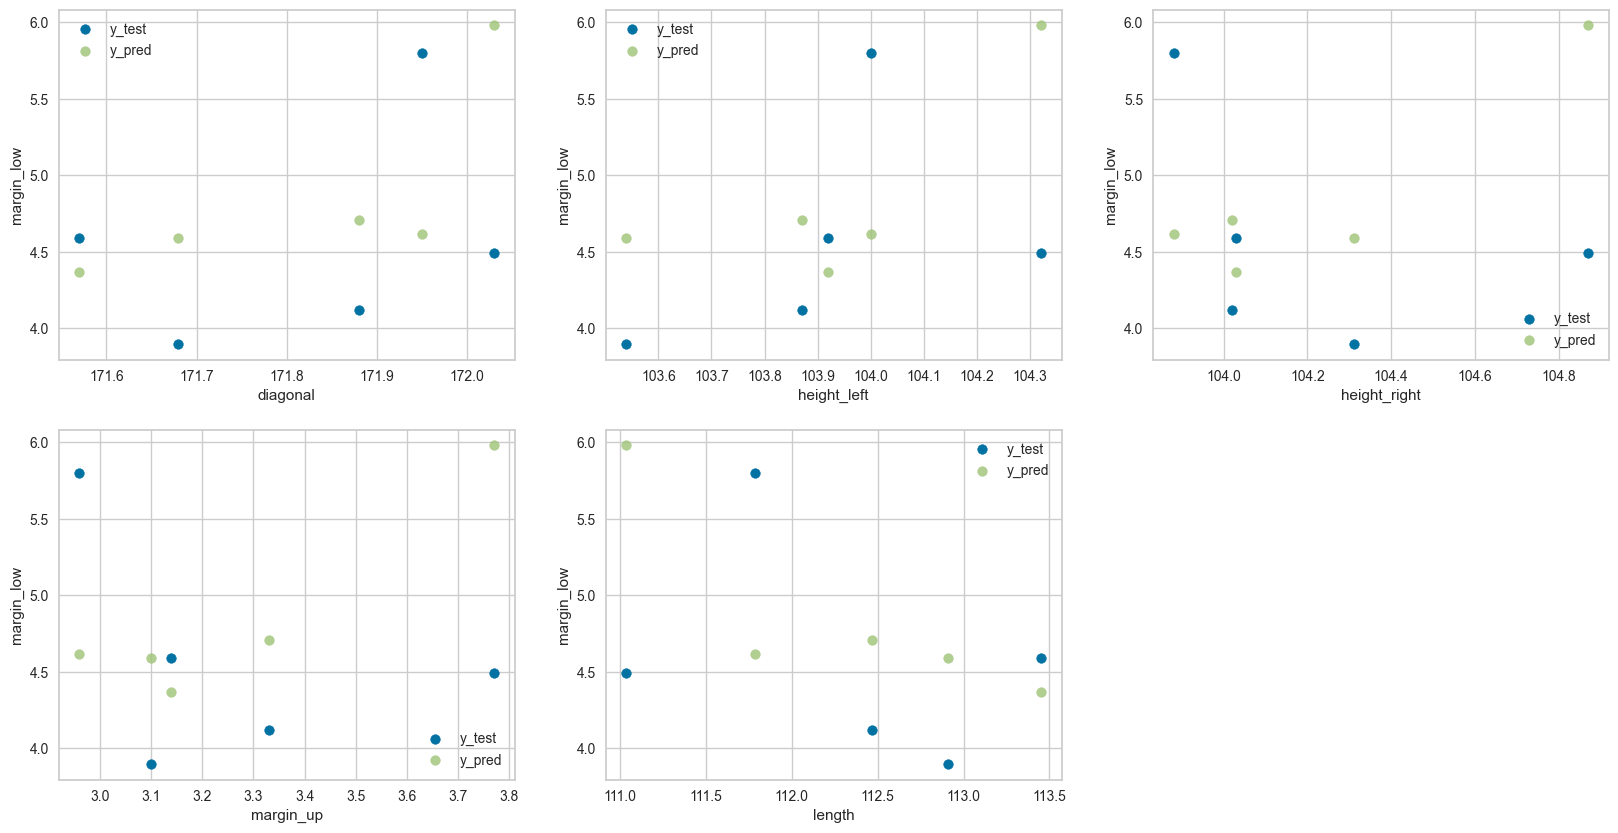

In [45]:
fig = plt.figure(figsize=(20, 10))

for i in range(X_marge_test.shape[1]):
    ax = fig.add_subplot(2,3, (i+1))
    plt.scatter(X_marge_test.iloc[:,i],y_marge_test,label="y_test")
    plt.scatter(X_marge_test.iloc[:,i],y_marge_predicted,label="y_pred", alpha=0.8)
    plt.xlabel(X_marge_test.columns[i])
    plt.ylabel("margin_low")
    plt.legend()

### Visualisation et analyse des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction développée.

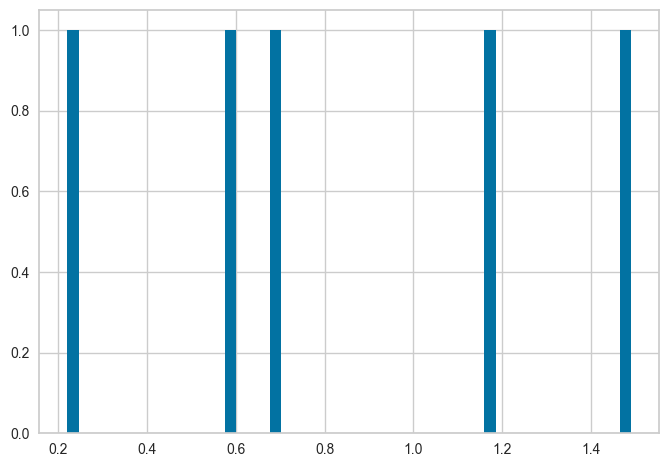

In [46]:
error_histogram(y_marge_test,y_marge_predicted)

Je calcule le nombre d'erreur < à 10%

In [47]:
precision=pred_inf_10_percent(y_marge_test.copy(),y_marge_predicted)
print (f"{precision:.2%} des données ont une erreur de prédiction inférieure à 10%.")

20.00% des données ont une erreur de prédiction inférieure à 10%.


## Régression linéaire multiple par Statsmodels

In [48]:
reg_lin_statsmodels = sm.OLS(y_marge_train, X_marge_train).fit()
#results=reg_lin_statsmodels.fit()
print(reg_lin_statsmodels.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              2309.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):                   1.32e-129
Time:                        20:07:57   Log-Likelihood:                         -99.582
No. Observations:                 141   AIC:                                      209.2
Df Residuals:                     136   BIC:                                      223.9
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

### Prédiction

In [49]:
y_marge_pred=np.round(reg_lin_statsmodels.predict(X_marge_test),2)
y_marge_pred

365     4.37
985     4.72
1234    4.64
1199    5.93
864     4.61
dtype: float64

### Evaluation du modèle

In [50]:
r2=r2_score(y_marge_test,y_marge_pred)
print(f'''Le coefficient de détermination (Score R² de précision) vaut: {r2:.2f}
=>le modèle décrit {r2:.2%} des variations de la marge inférieure d'un billet.''')

Le coefficient de détermination (Score R² de précision) vaut: -1.00
=>le modèle décrit -99.56% des variations de la marge inférieure d'un billet.


### Visualisation et analyse des erreurs

Nous allons vérifier 3 hypothèses sur les résidus : 
- Normalité via le **test de Shapiro-Wilk**
- Indépendance via le **test de Durbin-Watson** 
- Homogéinité via le **test de Breusch-Pagan**


**Normalité des résidus**<br>

J'affiche l’histogrammme des résidus et la densité gaussienne pour vérifier la normalité de la distribution. <br>
La normalité est vérifiée à partir de la standardisation des résidus (données déjà standardisée pour la régression multiple).
Appel de la fonction dédiée.

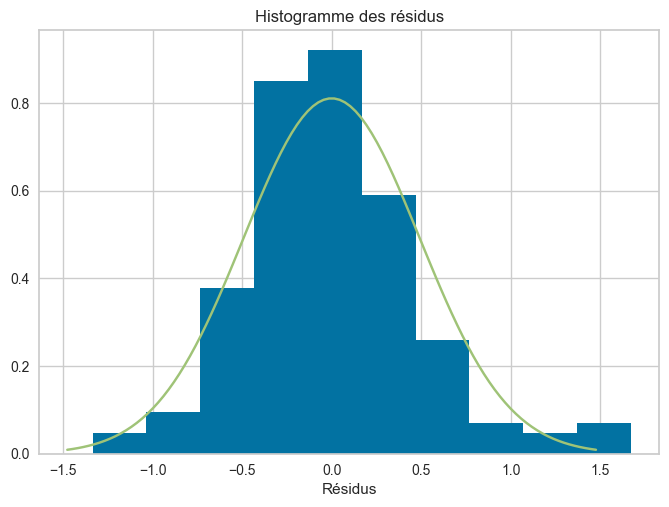

In [51]:
residual_histogram(reg_lin_statsmodels.resid)

<u>**Obervation**</u><br>
La distribution semble suivre une courbe normale qu'il faut confirmer par des chiffres.

In [52]:
shapiro_test(reg_lin_statsmodels)

Les résidus ne suivent pas une loi normale, p-value valant 0.00.


**Indépendance des résidus**<br>

In [53]:
durbin_watson_test(reg_lin_statsmodels)

Les résidus ne sont pas indépendants p-value valant 2.30.


**Homogéinité des résidus**<br>

In [54]:
breuschpagan_test(reg_lin_statsmodels)

Les résidus ne sont pas homogènes, p-value valant 0.00.


Je calcule le nombre d'erreur < à 10%

In [55]:
precision=pred_inf_10_percent(y_marge_test.copy(),y_marge_pred)
print (f"Soit {precision:.2%} des données ayant une erreur de prédiction inférieure à 10%.")

Soit 20.00% des données ayant une erreur de prédiction inférieure à 10%.


## Régression linéaire simple 

Puisque *margin_low* est anticorrélée à *length*, je vais me servir de cette corrélation pour prédire la valeur recherchée. 

### Séparation du jeu de données

In [56]:
X2=banknotes_df[["length"]]
X2

,length
1116,111.27
1368,112.30
422,112.76
451,113.03
861,113.65
...,...
1312,110.61
694,112.95
1001,111.29
322,113.33


In [57]:
y2=banknotes_df[["margin_low"]]
y2

,margin_low
1116,4.99
1368,5.65
422,4.04
451,4.07
861,4.43
...,...
1312,4.95
694,4.01
1001,4.96
322,4.24


### Echantillonnage

In [58]:
X_marge_train2, X_marge_test2, y_marge_train2, y_marge_test2 = train_test_split(X2, y2, test_size=0.3, random_state=42)

### Apprentissage

In [59]:
# Construction du modèle
lr2 = LinearRegression()

# Entrainement du modèle
model_reg_simple = lr2.fit(X_marge_train2, y_marge_train2)

### Prédiction

In [60]:
y_marge_predicted2 = model_reg_simple.predict(X_marge_test2)

### Evaluation du modèle

In [61]:
display_scores(y_marge_test2, y_marge_predicted2)

Racine carrée de l'erreur quadratique moyenne :  0.6129456674238094
Racine carrée logarithmique de l'erreur quadratique moyenne :  0.10881199726054147
Moyenne absolue des erreurs : 0.5050205968891116
Médiane absolue des erreurs : 0.45275062850219117
Le coefficient de détermination (Score R² de précision) vaut: 0.32
    => Le modèle décrit 32.08% des variations de la marge inférieure d'un billet.


### Visualisation des prédictions

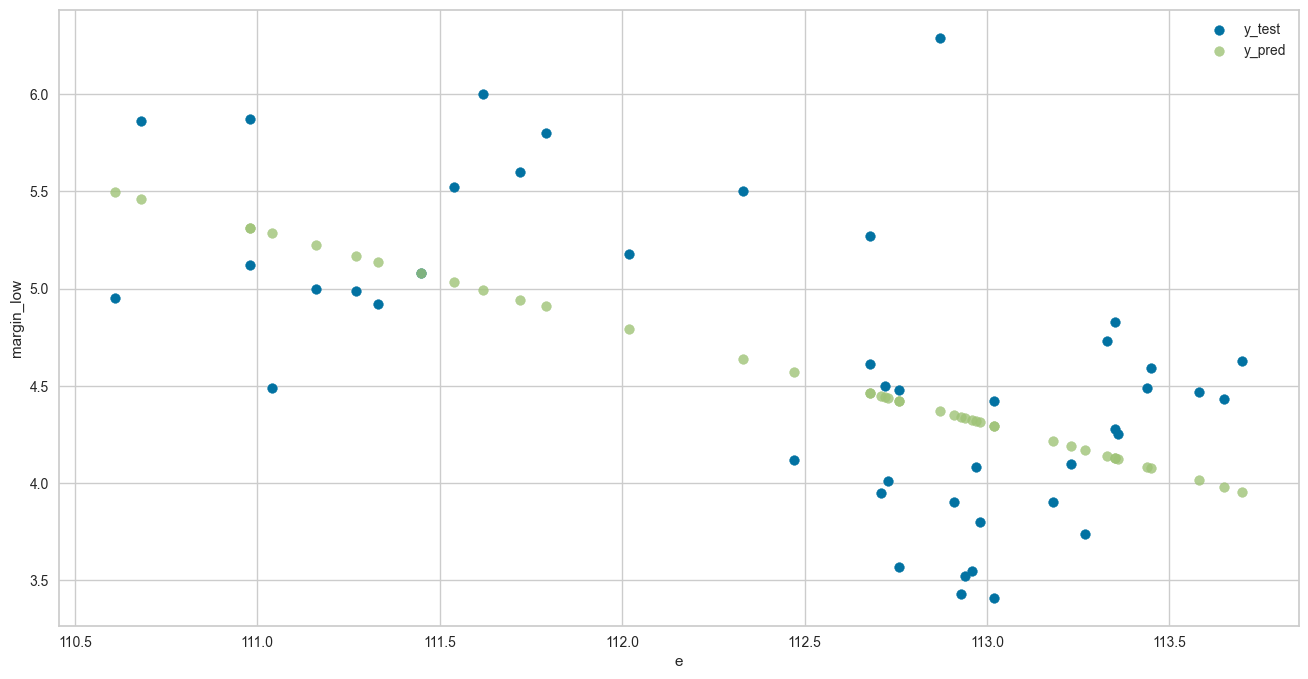

L'équation du modèle vaut : Y = -0.5 X +  60.74


In [62]:
fig = plt.figure(figsize=(16, 8))

plt.scatter(X_marge_test2,y_marge_test2,label="y_test")
plt.scatter(X_marge_test2,y_marge_predicted2,label="y_pred", alpha=0.8)
plt.xlabel("e")
plt.ylabel("margin_low")
plt.legend()
plt.show()


a = round(float(model_reg_simple.coef_),2)
b = round(float(model_reg_simple.intercept_),2)
print("L'équation du modèle vaut : Y =",a,"X + ",b)


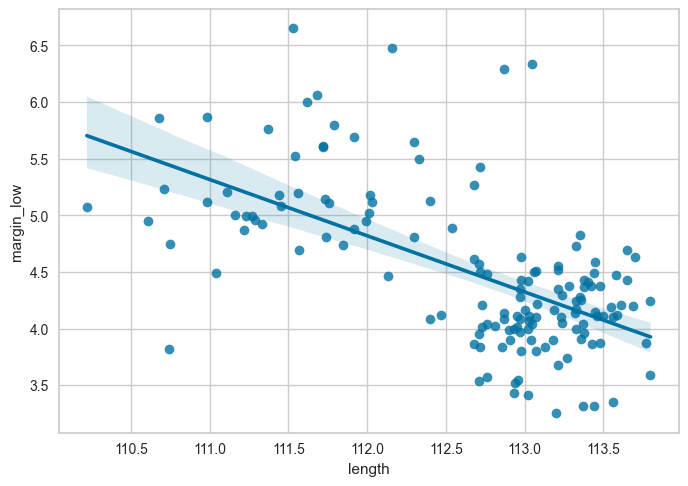

In [63]:
sns.regplot(x="length",y="margin_low",data=banknotes_df)
plt.show()

### Visualisation et analyses des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction développée.

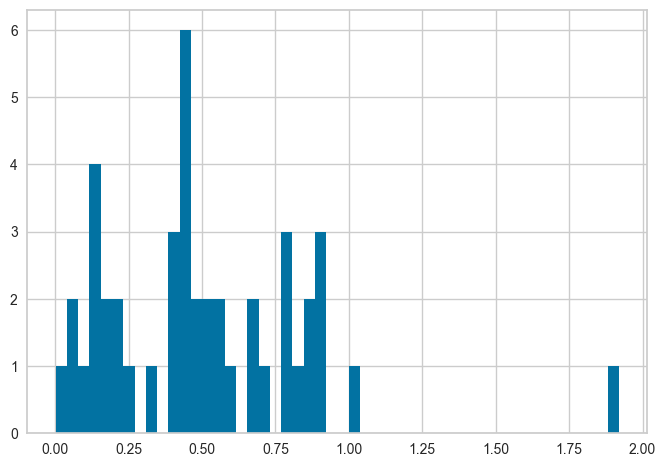

In [64]:
error_histogram(y_marge_test2,y_marge_predicted2)

Je calcule le nombre d'erreur < à 10%

In [65]:
precision=pred_inf_10_percent(y_marge_test2.copy(),y_marge_predicted2)
print (f"Soit {precision:.2%} des données ayant une erreur de prédiction inférieure à 10%.")

Soit 43.18% des données ayant une erreur de prédiction inférieure à 10%.


## Régression linéaire simple par statsmodels

In [66]:
reg_simple_statsmodels = sm.OLS(y_marge_train2, X_marge_train2).fit()

print(reg_simple_statsmodels.summary())

                                 OLS Regression Results                                
Dep. Variable:             margin_low   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              4274.
Date:                Thu, 01 Dec 2022   Prob (F-statistic):                    1.79e-84
Time:                        20:07:57   Log-Likelihood:                         -105.71
No. Observations:                 102   AIC:                                      213.4
Df Residuals:                     101   BIC:                                      216.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### Prédiction

In [67]:
y_pred2=np.round(reg_simple_statsmodels.predict(X_marge_test2),2)

### Evaluation du modèle

In [68]:
r2=r2_score(y_marge_test2,y_pred2)
print(f"""Le coefficient de détermination (Score R² de précision) vaut: {r2:.2f}
=> Le modèle décrit {r2:.2%} des variations de la marge inférieure d'un billet.""")

Le coefficient de détermination (Score R² de précision) vaut: -0.12
=> Le modèle décrit -12.32% des variations de la marge inférieure d'un billet.


### Visualisation et analyse des erreurs

**Normalité des résidus**

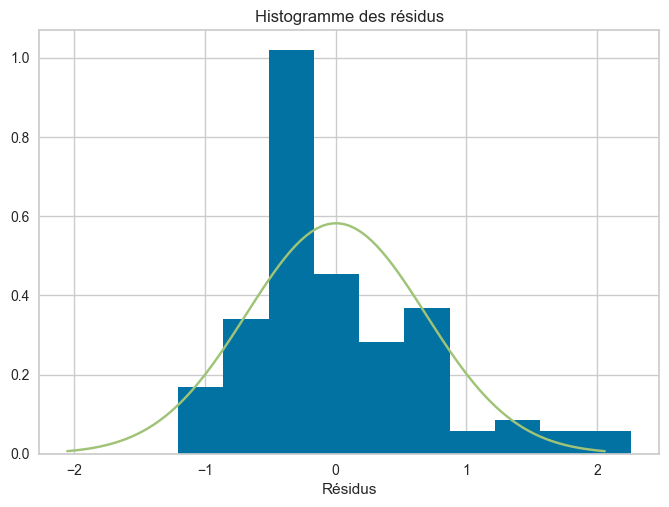

In [69]:
residual_histogram(reg_simple_statsmodels.resid)

<u>**Obervation**</u><br>
La distribution ne semble pas suivre une courbe normale. Je le confirme avec le test de Shapiro-Wilk qui teste la normalité des résidus où :

In [70]:
shapiro_test(reg_simple_statsmodels)

Les résidus ne suivent pas une loi normale, p-value valant 0.00.


**Indépendance des résidus**

In [71]:
durbin_watson_test(reg_simple_statsmodels)

Les résidus ne sont pas indépendants p-value valant 2.32.


**Homogéinité des résidus**

In [72]:
breuschpagan_test(reg_simple_statsmodels)

Les résidus ne sont pas homogènes, p-value valant 0.00.


Je calcule le nombre d'erreur < à 10%

In [73]:
precision=pred_inf_10_percent(y_marge_test2.copy(),y_pred2)
print (f"Soit {precision:.2%} des données ayant une erreur de prédiction inférieure à 10%.")

Soit 38.64% des données ayant une erreur de prédiction inférieure à 10%.


## KNNImputer (avec GridSearchCV) A SUPPRIMER

In [74]:
X_knni = banknotes_df.copy()
X_knni = X_knni.drop(columns=["is_genuine","margin_low"])
X_knni

,diagonal,height_left,height_right,margin_up,length
1116,172.26,103.90,104.12,3.42,111.27
1368,171.65,104.32,104.38,3.24,112.30
422,171.53,103.53,103.63,2.96,112.76
451,172.17,103.79,103.54,2.78,113.03
861,171.86,104.21,103.74,2.90,113.65
...,...,...,...,...,...
1312,171.92,104.37,104.05,3.04,110.61
694,171.49,103.77,103.60,3.09,112.95
1001,171.92,103.86,104.30,3.13,111.29
322,171.75,104.13,103.91,2.97,113.33


In [75]:
y_knni=banknotes_df.copy()
y_knni=y_knni[["margin_low"]]
y_knni

,margin_low
1116,4.99
1368,5.65
422,4.04
451,4.07
861,4.43
...,...
1312,4.95
694,4.01
1001,4.96
322,4.24


### Echantillonnage


In [76]:
X_knni_train, X_knni_test, y_knni_train, y_knni_test = train_test_split(X_knni,y_knni,train_size=0.7, random_state=42)

Je standardise mes données d'entraînement et j'applique ensuite la transformation sur mes données d'entraînement et de test

In [77]:
scaler_X_knni_train = preprocessing.StandardScaler()
X_knni_train_std=scaler_X_knni_train.fit_transform(X_knni_train)
X_knni_test_std = scaler_X_knni_train.transform(X_knni_test)

Je créé une pipeline qui va contenir mon knnimputer et un algorithme de régression.<br>


In [78]:
model = make_pipeline(KNNImputer(), LinearRegression())

Je vais utiliser le transformeur avec GridSearchCV afin d'optimiser les caractéristiques de mon KNNImputer. <br>
Je créé un dictionnaire de paramètres de ce que je souhaite optimiser, principalement le nombre de voisins optimal.

In [79]:
params = {
    'knnimputer__n_neighbors' : np.arange(1,31),
    'knnimputer__weights': ['uniform', 'distance']
}

In [80]:
grid = GridSearchCV(model,param_grid=params,cv=10)

J'entraîne ma grid sur mes données

In [81]:
grid.fit(X_knni_train_std, y_knni_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('knnimputer', KNNImputer()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'knnimputer__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                         'knnimputer__weights': ['uniform', 'distance']})

Affichage des meilleurs paramètres.

In [82]:
print("Les meilleurs paramètres sont : ",grid.best_params_)

Les meilleurs paramètres sont :  {'knnimputer__n_neighbors': 1, 'knnimputer__weights': 'uniform'}


In [83]:
y_marge_knni_predicted = np.round(grid.predict(X_knni_test_std),2)

### Evaluation du modèle
Le score R² évalue la performance du modèle par rapport à la variance des données.<br>
La **M**ean **S**quared **E**rror pénalise beaucoup lus les grandes erreurs que la MAE. Utile quand on accorde une grande importance aux grandes erreurs.<br> 
Avec la **M**ean **A**bsolute **E**rror, l'importance d'une erreur est linéaire avec son amplitude. Si les grandes erreurs sont provoquées par des erreurs abérrantes, alors il vaut mieux utiliser cet évaluateur.<br>
La **M**edian **A**bsolute **E**rror est encore moins sensible aux grandes erreurs.

In [84]:
display_scores(y_knni_test, y_marge_knni_predicted)

Racine carrée de l'erreur quadratique moyenne :  0.5934203630418553
Racine carrée logarithmique de l'erreur quadratique moyenne :  0.10376857831005529
Moyenne absolue des erreurs : 0.48295454545454536
Médiane absolue des erreurs : 0.41999999999999993
Le coefficient de détermination (Score R² de précision) vaut: 0.36
    => Le modèle décrit 36.34% des variations de la marge inférieure d'un billet.


### Visualisation des prédictions
Affichage de la distribution de chaque variable explicative par rapport à la variable prédictive

In [85]:
y_marge_knni_predicted

array([[4.32],
       [4.67],
       [4.62],
       [5.91],
       [4.51],
       [4.48],
       [4.69],
       [4.14],
       [5.06],
       [4.07],
       [5.75],
       [5.7 ],
       [5.21],
       [4.94],
       [4.23],
       [4.24],
       [4.38],
       [4.53],
       [4.28],
       [4.04],
       [4.4 ],
       [5.59],
       [4.32],
       [4.79],
       [5.02],
       [4.02],
       [4.38],
       [3.98],
       [3.97],
       [4.24],
       [4.01],
       [5.37],
       [4.06],
       [4.93],
       [4.2 ],
       [5.2 ],
       [4.59],
       [4.34],
       [4.23],
       [4.97],
       [4.13],
       [4.19],
       [4.39],
       [5.11]])

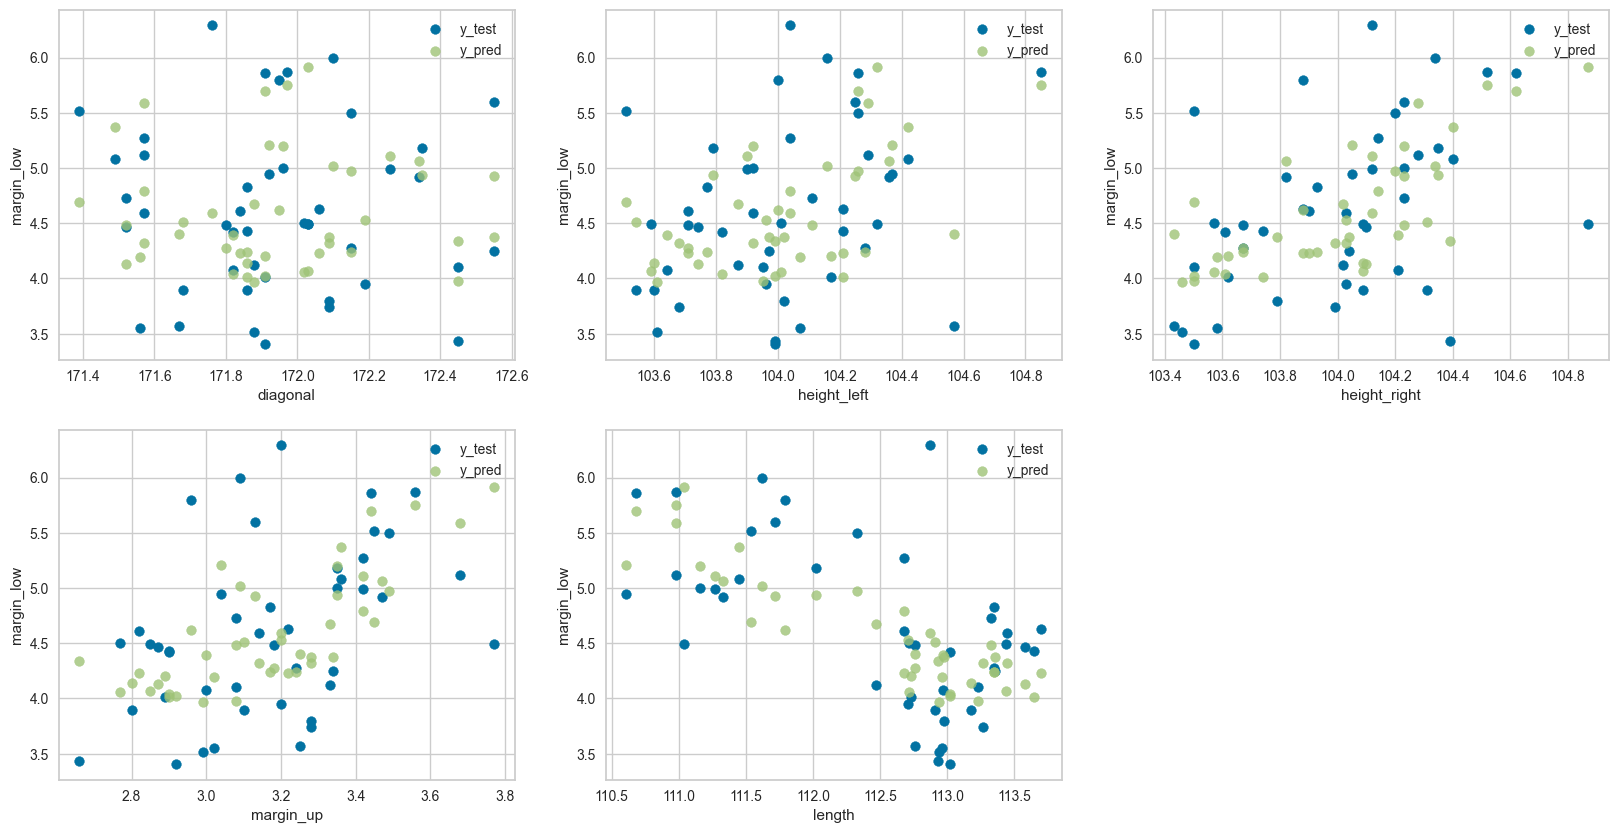

In [86]:
fig = plt.figure(figsize=(20, 10))

for i in range(X_marge_test.shape[1]):
    ax = fig.add_subplot(2,3, (i+1))
    plt.scatter(X_knni_test.iloc[:,i],y_knni_test,label="y_test")
    plt.scatter(X_knni_test.iloc[:,i],y_marge_knni_predicted,label="y_pred", alpha=0.8)
    plt.xlabel(X_knni_test.columns[i])
    plt.ylabel("margin_low")
    plt.legend()

### Visualisation des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction développée.

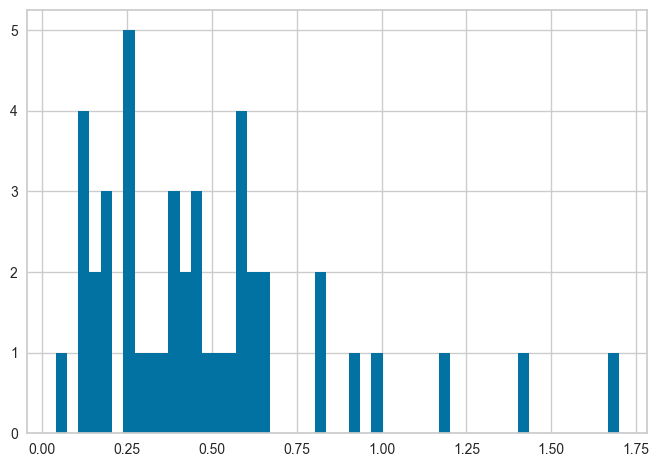

In [87]:
error_histogram(y_knni_test,y_marge_knni_predicted)

Je calcule le nombre d'erreur < à 10%

In [88]:
precision=pred_inf_10_percent(y_knni_test.copy(), y_marge_knni_predicted)
print (f"{precision:.2%} des données ont une erreur de prédiction inférieure à 10%.")

61.36% des données ont une erreur de prédiction inférieure à 10%.


## KNNImputer

La méthode KNNImputer ne s'applique que sur des données numériques.<br>
Je vais dupliquer mon dataframe sans les NaN puis utiliser la totalité de ce dataframe dans lequel je vais injecter 2.5% de nan.<br>
Je vais ensuite vérifier le résultat par rapport au dataframe d'origine et regarder les écarts.

In [89]:
banknotes_df_KNNI = banknotes_df.copy()
banknotes_df_KNNI=banknotes_df_KNNI.drop(columns="is_genuine")
banknotes_df_KNNI.columns

Index(['diagonal', 'height_left', 'height_right', 'margin_up', 'length',
       'margin_low'],
      dtype='object')

J'injecte 2.5% de NaN dans la colonne margin_low, soit 37 valeurs vides au hasard.


In [90]:
banknotes_df_knn_with_Nan=banknotes_df_KNNI.copy()
banknotes_df_knn_with_Nan['margin_low'] = banknotes_df_KNNI['margin_low'].sample(frac=0.975, random_state=42)
banknotes_df_knn_with_Nan.isna().sum()

diagonal        0
height_left     0
height_right    0
margin_up       0
length          0
margin_low      4
dtype: int64

Je sauvegarde les valeurs nulles dans un dataframe ainsi que les indexes.

In [91]:
NaN_banknotes_df_knn=banknotes_df_knn_with_Nan[banknotes_df_knn_with_Nan.margin_low.isna()]
NaN_banknotes_df_knn.head(5)

,diagonal,height_left,height_right,margin_up,length,margin_low
1268,171.94,104.38,103.81,3.39,111.22,NaN
479,171.87,103.86,103.27,3.14,113.32,NaN
44,171.79,103.83,103.76,3.18,112.90,NaN
874,172.22,103.75,103.91,3.19,113.06,NaN


In [92]:
index_NaN=NaN_banknotes_df_knn.index
index_NaN

Int64Index([1268, 479, 44, 874], dtype='int64')

### Détermination du meilleur k

Je créé mon dataframe ne contenant que mes valeurs avant remplacement par des Nan

In [93]:
true_values=pd.DataFrame(banknotes_df_KNNI.margin_low.loc[index_NaN])

Je teste mon imputation pour plusieurs valeurs de k

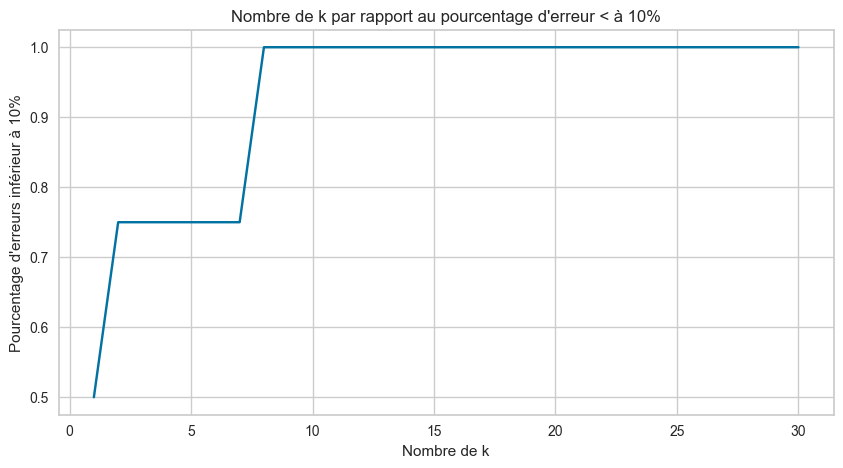

In [94]:
result=pd.DataFrame(columns=["k","Pourcentage erreur <10%"])
for i in range (1,31) :
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=i, weights="distance")
    imputer.fit(banknotes_df_knn_with_Nan)
    banknotes_df_knn_pred = pd.DataFrame(imputer.transform(banknotes_df_knn_with_Nan), columns = banknotes_df_knn_with_Nan.columns, index=banknotes_df_knn_with_Nan.index)
    banknotes_df_knn_pred = banknotes_df_knn_pred.round(2)
    
    # Je stocke la valeur prédite
    pred_values = banknotes_df_knn_pred.margin_low.loc[index_NaN]

    #J'évalue mon modèle
    precision=pred_inf_10_percent(true_values.copy(),pred_values)

    # Je stocke mes résultats d'évaluation
    result = pd.concat([result,pd.DataFrame.from_records([
                       {'k': i,"Pourcentage erreur <10%":precision}])], ignore_index=True)
    # result = result.append({'k': i,"Pourcentage erreur <10%":precision}, ignore_index=True)
plt.figure(figsize=(10,5))
plt.plot(result.k,result["Pourcentage erreur <10%"])
plt.xlabel("Nombre de k")
plt.ylabel("Pourcentage d'erreurs inférieur à 10%")
plt.title("Nombre de k par rapport au pourcentage d'erreur < à 10%")
plt.show()

In [95]:
optimal_k = max(result["Pourcentage erreur <10%"])
optimal_k = result["k"][result["Pourcentage erreur <10%"]==optimal_k]
if optimal_k.shape[0]>1:
    optimal_k=min(optimal_k)
    print(f"La valeur de K la plus optimisée est {int(optimal_k)}.")
else:
    print(f"La valeur de K la plus optimisée est {int(optimal_k)}.")

La valeur de K la plus optimisée est 8.


### Imputation

J'impute avec le k optimal

In [96]:
imputer = KNNImputer(n_neighbors=optimal_k, weights="distance")
imputer.fit(banknotes_df_knn_with_Nan)
banknotes_df_knn_pred = pd.DataFrame(imputer.transform(banknotes_df_knn_with_Nan), columns = banknotes_df_knn_with_Nan.columns, index=banknotes_df_knn_with_Nan.index)
banknotes_df_knn_pred=banknotes_df_knn_pred.round(2)
banknotes_df_knn_pred.isna().sum()

diagonal        0
height_left     0
height_right    0
margin_up       0
length          0
margin_low      0
dtype: int64

### Evaluation du modèle

In [97]:
precision=pred_inf_10_percent(true_values,banknotes_df_knn_pred.margin_low)
print (f"{precision:.2%} des données ont une erreur de prédiction inférieure à 10%.")

100.00% des données ont une erreur de prédiction inférieure à 10%.


### Visualisation des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction développée.<br>
Je transforme mon pred_values en array pour le passer en paramètre de error_histogram, et je ne conserve que margin_low de mon df.

In [98]:
pred_values=np.array(pred_values).reshape(-1,1)

In [99]:
true_values=pd.DataFrame(true_values.margin_low)

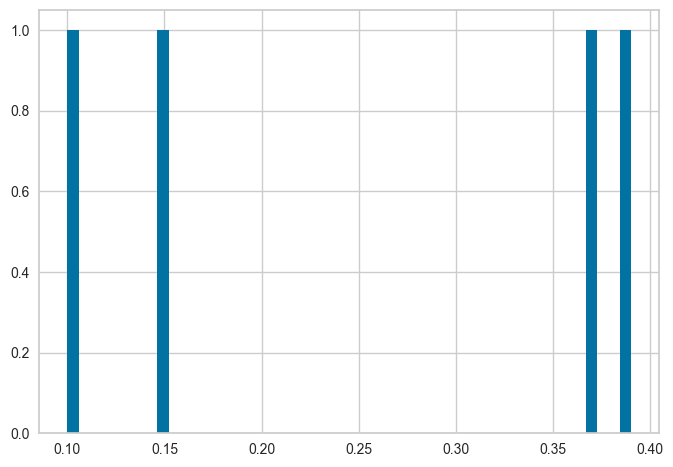

In [100]:
error_histogram(true_values,pred_values)

### Visualisation des prédictions

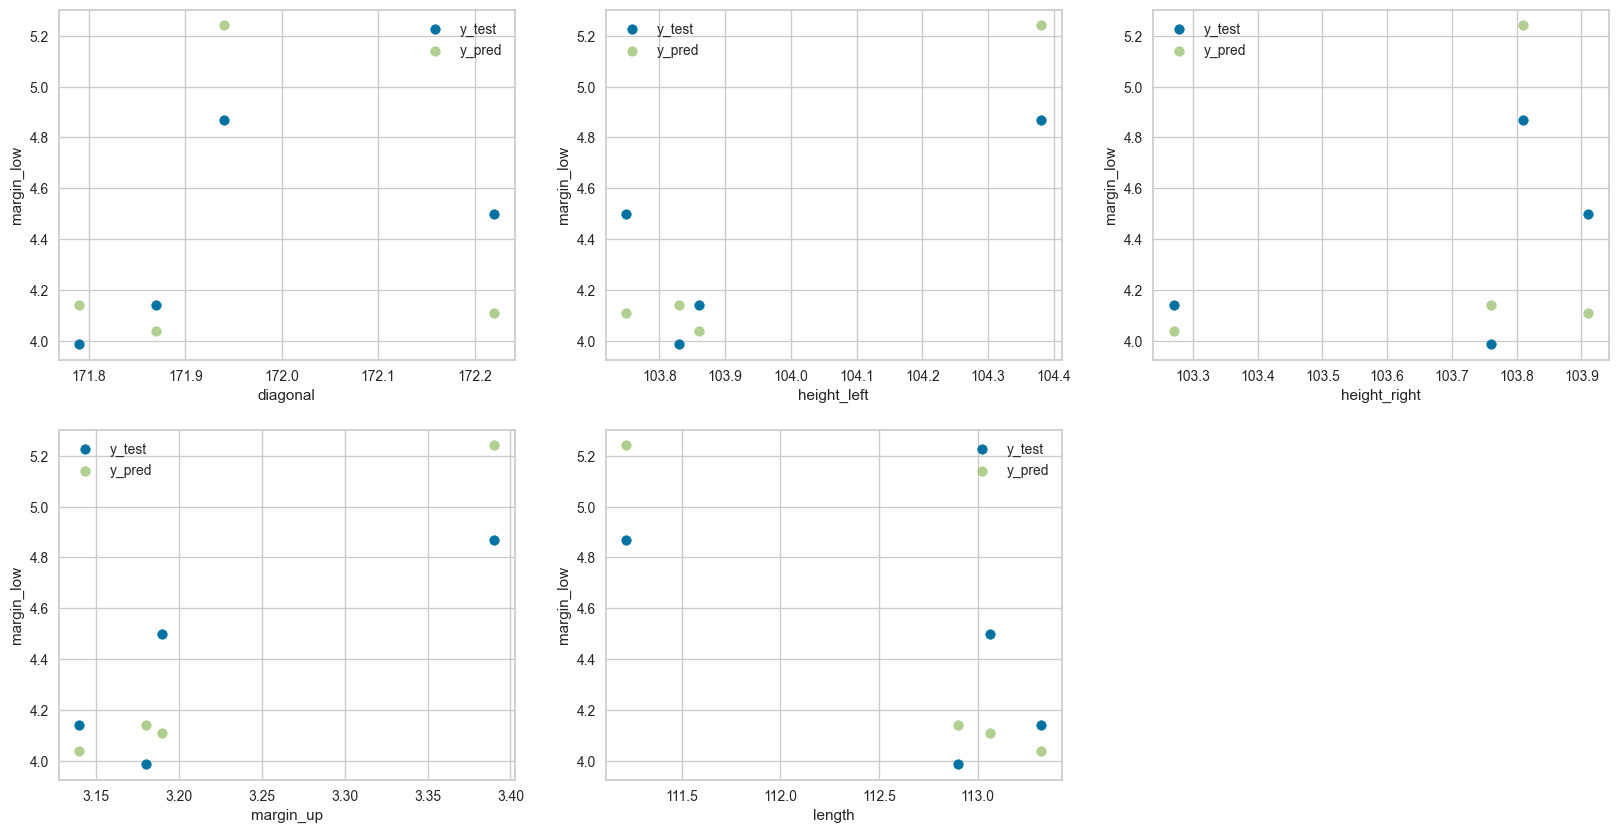

In [101]:
fig = plt.figure(figsize=(20, 10))

for i in range(banknotes_df_KNNI.shape[1]):

    if banknotes_df_KNNI.columns[i]!="margin_low":
        ax = fig.add_subplot(2,3, (i+1))
        plt.scatter(banknotes_df_KNNI.loc[index_NaN,banknotes_df_KNNI.columns[i]],true_values,label="y_test")
        plt.scatter(banknotes_df_KNNI.loc[index_NaN,banknotes_df_KNNI.columns[i]],pred_values,label="y_pred", alpha=0.8)
        plt.xlabel(banknotes_df_KNNI.columns[i])
        plt.ylabel("margin_low")
        plt.legend()

## KNN Regressor

On utilise la méthode des proches voisins mais cette fois avec une méthode qui va prédire les valeurs manquantes.

KNeighborsRegressor est utilisé pour prédire les variables de réponse, tandis que KNNImputer est utilisé pour remplacer les valeurs manquantes sur les variables de caractéristiques.

### Séparation du jeu de données

In [102]:
data = banknotes_df[banknotes_df.columns.difference(["is_genuine","margin_low"],sort=False)].copy() # sort = False to keep the columns in the initial order
data

,diagonal,height_left,height_right,margin_up,length
1116,172.26,103.90,104.12,3.42,111.27
1368,171.65,104.32,104.38,3.24,112.30
422,171.53,103.53,103.63,2.96,112.76
451,172.17,103.79,103.54,2.78,113.03
861,171.86,104.21,103.74,2.90,113.65
...,...,...,...,...,...
1312,171.92,104.37,104.05,3.04,110.61
694,171.49,103.77,103.60,3.09,112.95
1001,171.92,103.86,104.30,3.13,111.29
322,171.75,104.13,103.91,2.97,113.33


In [103]:
target = banknotes_df[["margin_low"]]
target

,margin_low
1116,4.99
1368,5.65
422,4.04
451,4.07
861,4.43
...,...
1312,4.95
694,4.01
1001,4.96
322,4.24


### Echantillonnage

In [104]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(data,target,train_size=0.7)

Standardisation sur les données d'entraînement

In [105]:
#scaler_X_train_knn = preprocessing.StandardScaler()
#X_train_knn_std=scaler_X_train_knn.fit_transform(X_train_knn)

J'applique la standardisation sur mon jeu de test 

In [106]:
#X_train_knn_std = std_scale.transform(X_train_knn)
#X_test_knn_std = scaler_X_train_knn.transform(X_test_knn)

Je reforme mes dataframe "cassés" après la standardisation

In [107]:
#X_train_knn=pd.DataFrame(X_train_knn,columns=X_train_knn.columns,index=X_train_knn.index)
#X_train_knn

### Apprentissage

Construction du modèle. Je démarre par le k optimal de ma précédente imputation.

In [108]:
print (f"Apprentissage avec {optimal_k} voisins.")
model_knn_imputer = KNeighborsRegressor(n_neighbors=optimal_k) #https://stackoverflow.com/questions/45645716/unknown-label-type-continuous

Apprentissage avec 8 voisins.


In [109]:
'''
param ={
    'weights': ['uniform', 'distance'],
    'n_neighbors' : np.arange(1,31),
    'metric':['euclidean','manhattan','minkowski']
}
grid = GridSearchCV(KNeighborsRegressor(),param_grid=param,cv=5,scoring="r2")
grid.fit(X_train_knn, y_train_knn)
grid.best_params_

puis

model_reg_log=grid.best_estimator_
y_pred=model_reg_log.predict(X_test)
'''


'\nparam ={\n    \'weights\': [\'uniform\', \'distance\'],\n    \'n_neighbors\' : np.arange(1,31),\n    \'metric\':[\'euclidean\',\'manhattan\',\'minkowski\']\n}\ngrid = GridSearchCV(KNeighborsRegressor(),param_grid=param,cv=5,scoring="r2")\ngrid.fit(X_train_knn, y_train_knn)\ngrid.best_params_\n\npuis\n\nmodel_reg_log=grid.best_estimator_\ny_pred=model_reg_log.predict(X_test)\n'

Entraînement du modèle

In [110]:
model_knn_imputer.fit(X_train_knn, y_train_knn)

KNeighborsRegressor(n_neighbors=8)

### Evaluation du modèle

In [111]:
print(f"Le score vaut {model_knn_imputer.score(X_test_knn,y_test_knn):.2%}")

Le score vaut 49.80%


In [112]:
print (f"Le pourcentage d'erreur est {1-model_knn_imputer.score(X_test_knn,y_test_knn):.2%}")

Le pourcentage d'erreur est 50.20%


**1re méthode pour trouver le k optimal**

Pour améliorer mon modèle, je vais utiliser une boucle pour détecter le meilleur k avec :
- La méthode de cross-validation
- Sans la méthode cross validation



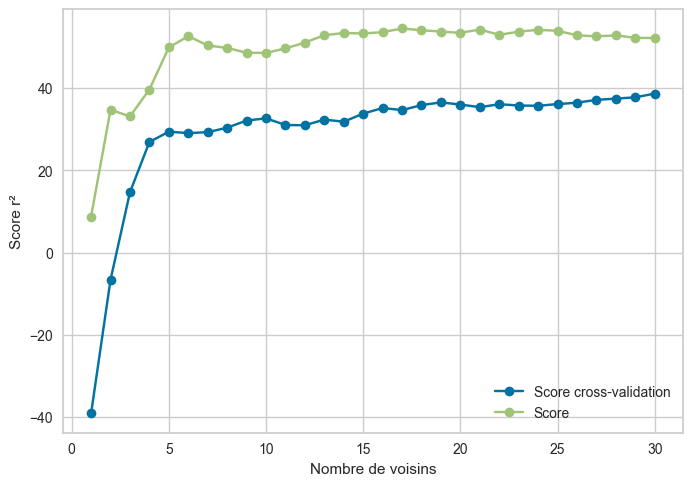

In [113]:
scores_cv=[]
scores = []
for k in range (1,31):
    model_knn_imputer = KNeighborsRegressor(n_neighbors=k)
    score_cv=cross_val_score(model_knn_imputer,X_train_knn,y_train_knn, cv=10,scoring="r2")
    scores_cv.append(100*score_cv.mean())
    score=model_knn_imputer.fit(X_train_knn, y_train_knn).score(X_test_knn,y_test_knn)
    scores.append(100*score.mean())
plt.plot(range(1,31),scores_cv,'-o',label="Score cross-validation")
plt.plot(range(1,31),scores,'-o',label="Score")
plt.xlabel("Nombre de voisins")
plt.ylabel("Score r²")
plt.legend()
plt.show()

Les courbes sont proches. On va se baser sur le meilleur score de cross-validation

In [114]:
best_score=0# j'initialise haut la plus basse valeur d'erreur
for index,score_cv in enumerate(scores_cv):
    if best_score < score_cv: 
        best_score=score_cv
        optimal_k=index+1 # +2 pour correspondre à la liste des k

print (f"Notre classifieur optimal est {optimal_k}")

Notre classifieur optimal est 30


**2e méthode pour trouver le k optimal**

In [115]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':np.arange(1,31)}#, 'weights':["uniform","distance"]}

# Choisir un score à optimiser, ici r2
score = 'r2'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf_knn_reg = GridSearchCV(neighbors.KNeighborsRegressor(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=10,          # nombre de folds de validation croisée
    scoring=score,   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf_knn_reg.fit(X_train_knn, y_train_knn)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:",clf_knn_reg.best_params_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'n_neighbors': 30}


In [116]:
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf_knn_reg.cv_results_['mean_test_score'], # score moyen
        clf_knn_reg.cv_results_['std_test_score'],  # écart-type du score
        clf_knn_reg.cv_results_['params']           # valeur de l'hyperparamètre
    ):
    print(f"{score} = {mean:.3f} (+/-{std*2:.03f}) for {params}")

Résultats de la validation croisée :
r2 = -0.392 (+/-2.800) for {'n_neighbors': 1}
r2 = -0.066 (+/-1.192) for {'n_neighbors': 2}
r2 = 0.147 (+/-0.886) for {'n_neighbors': 3}
r2 = 0.269 (+/-0.738) for {'n_neighbors': 4}
r2 = 0.294 (+/-0.771) for {'n_neighbors': 5}
r2 = 0.291 (+/-0.777) for {'n_neighbors': 6}
r2 = 0.293 (+/-0.799) for {'n_neighbors': 7}
r2 = 0.304 (+/-0.843) for {'n_neighbors': 8}
r2 = 0.321 (+/-0.804) for {'n_neighbors': 9}
r2 = 0.327 (+/-0.859) for {'n_neighbors': 10}
r2 = 0.310 (+/-0.875) for {'n_neighbors': 11}
r2 = 0.310 (+/-0.856) for {'n_neighbors': 12}
r2 = 0.324 (+/-0.817) for {'n_neighbors': 13}
r2 = 0.318 (+/-0.862) for {'n_neighbors': 14}
r2 = 0.338 (+/-0.792) for {'n_neighbors': 15}
r2 = 0.352 (+/-0.737) for {'n_neighbors': 16}
r2 = 0.347 (+/-0.712) for {'n_neighbors': 17}
r2 = 0.359 (+/-0.689) for {'n_neighbors': 18}
r2 = 0.365 (+/-0.656) for {'n_neighbors': 19}
r2 = 0.360 (+/-0.654) for {'n_neighbors': 20}
r2 = 0.354 (+/-0.630) for {'n_neighbors': 21}
r2 =

Je choisis l'un des 2 modèles entre model_knn_imputer et clf qui retournent le même résultat.<br>
Si je choisissais model_knn_imputer, il faudrait que je passe le k optimal <br>
- model_knn_imputer = KNeighborsRegressor(n_neighbors=optimal_k) puis que je le réentraine<br>
- model_knn_imputer.fit(X_train_knn, y_train_knn) et enfin que je prédise<br>
- y_predicted_knn=np.round(model_knn_imputer.predict(X_test_knn),2)

In [117]:
y_predicted_knn = clf_knn_reg.predict(X_test_knn)

In [118]:
print(f"Le score r2 vaut {clf_knn_reg.score(X_test_knn,y_test_knn):.2%}")

Le score r2 vaut 52.21%


In [119]:
print (f"Le pourcentage d'erreur est {1-clf_knn_reg.score(X_test_knn,y_test_knn):.2%}")

Le pourcentage d'erreur est 47.79%


### Visualisation des prédictions
Affichage de la distribution de chaque variable explicative par rapport à la variable prédictive

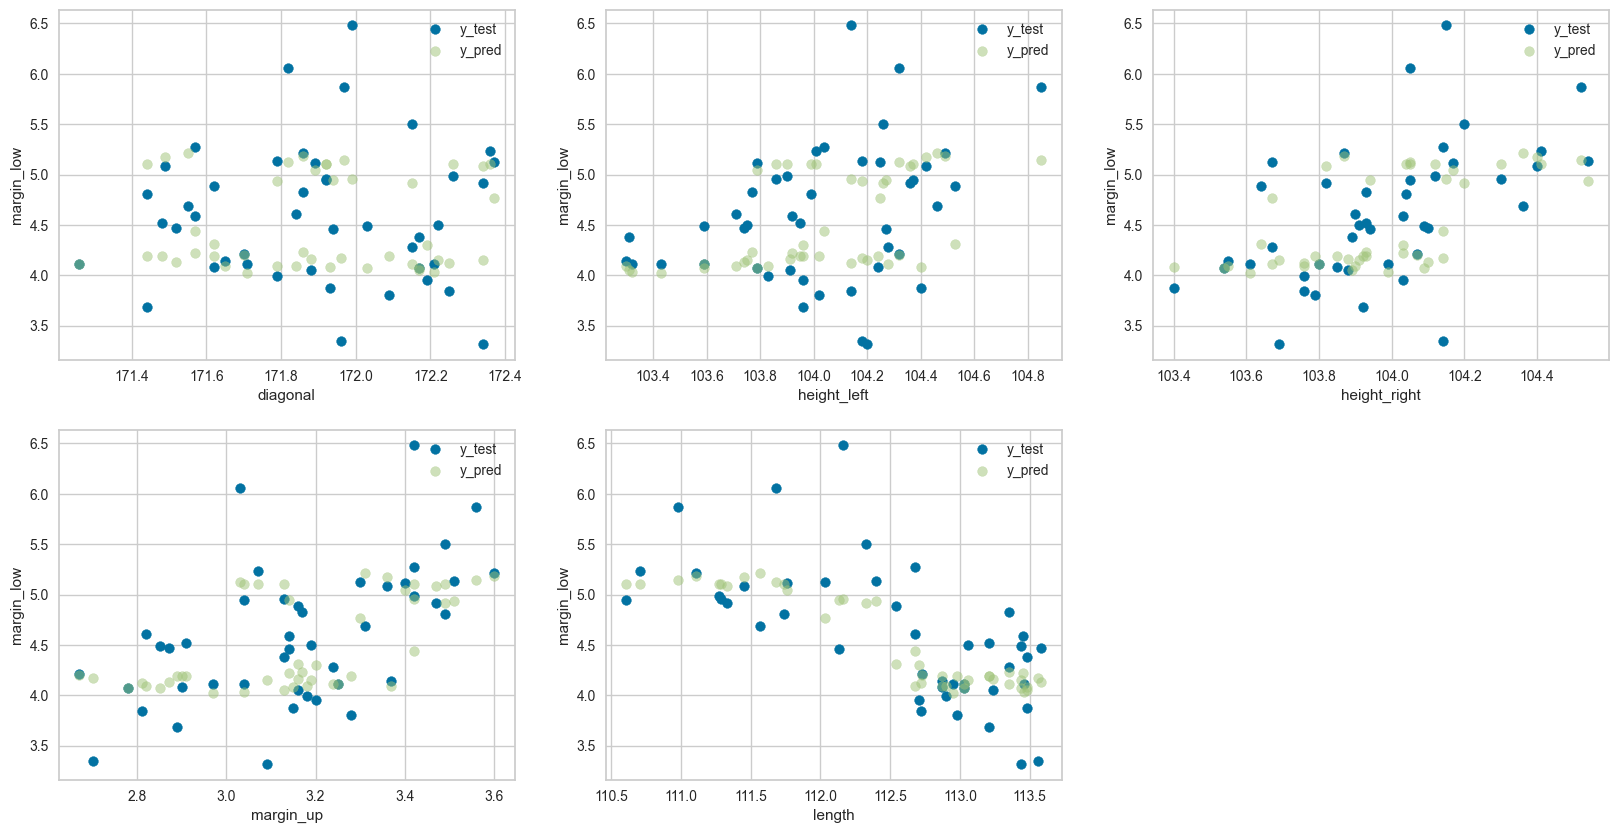

In [120]:
fig = plt.figure(figsize=(20, 10))

for i in range(X_test_knn.shape[1]):
    ax = fig.add_subplot(2,3, (i+1))
    plt.scatter(X_test_knn.iloc[:,i],y_test_knn,label="y_test")
    plt.scatter(X_test_knn.iloc[:,i],y_predicted_knn,label="y_pred", alpha=0.5)
    plt.xlabel(X_test_knn.columns[i])
    plt.ylabel("margin_low")
    plt.legend()

In [121]:
display_scores(y_test_knn, y_predicted_knn)

Racine carrée de l'erreur quadratique moyenne :  0.46359516800542666
Racine carrée logarithmique de l'erreur quadratique moyenne :  0.08092483363597996
Moyenne absolue des erreurs : 0.3472878787878788
Médiane absolue des erreurs : 0.3125
Le coefficient de détermination (Score R² de précision) vaut: 0.52
    => Le modèle décrit 52.21% des variations de la marge inférieure d'un billet.


### Visualisation des erreurs
Je trace l'histogramme de mes erreurs en calculant la valeur absolue entre y_test et y_pred (erreur moyenne absolue) via la fonction développée.

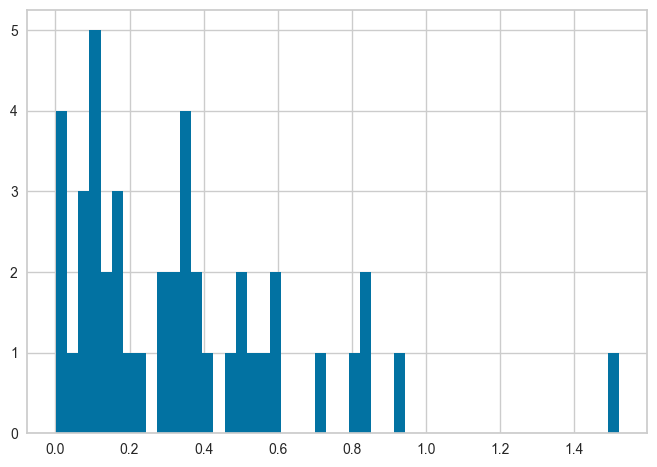

In [122]:
error_histogram(y_test_knn,y_predicted_knn)

Je mets les informations dans un dataframe

In [123]:
precision=pred_inf_10_percent(y_test_knn,y_predicted_knn)
print (f"{precision:.2%} des données ont une erreur de prédiction inférieure à 10%.")

68.18% des données ont une erreur de prédiction inférieure à 10%.


## Conclusion

**La méthode obtenant la meilleure évaluation est celle du KNN Regressor : meilleur score r2 et meilleur score en terme de pourcentage d'erreurs inférieures à 10%.<br>**

La méthode de régression linéaire multiple donne le meilleur scrore r2 des régressions linéaires. Mais les conditions d'application ne sont pas toutes respectées (normalité et homoscédasticté des résidus).<br>
Nous allons donc procéder à l'imputation finale des valeurs manquantes via les valeurs obtenues par la régression des KNN.

Je récupère le dataframe null_notes_mask contenant uniquement les valeurs nulles sur lesquelles nous allons procéder à l'imputation

In [124]:
null_notes_mask.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
413,True,172.30,103.66,103.50,3.16,112.95,NaN
654,True,171.97,103.69,103.54,2.70,112.79,NaN
798,True,171.96,103.84,103.62,3.01,114.44,NaN
481,True,171.81,103.53,103.96,2.71,113.99,NaN


Je supprime les colonnes *is_genuine* et *margin_low* pour avoir le même dataframe en entrée que lorsque j'ai entraîné mon modèle.

In [125]:
values_to_predict=null_notes_mask.drop(columns=["is_genuine","margin_low"])
values_to_predict.head()

,diagonal,height_left,height_right,margin_up,length
413,172.30,103.66,103.50,3.16,112.95
654,171.97,103.69,103.54,2.70,112.79
798,171.96,103.84,103.62,3.01,114.44
481,171.81,103.53,103.96,2.71,113.99


Je centre et réduis mes données et les remets au format dataframe (pour régression linéaire multiple) 

In [126]:
#values_to_predict_std=std_scale.transform(values_to_predict)
#values_to_predict_std=pd.DataFrame(values_to_predict_std, columns=values_to_predict.columns)
#values_to_predict_std.head()

In [127]:
predict_margin_low = np.round(clf_knn_reg.predict(values_to_predict),2) #.values si warning et modèle de régression linéaire

Je mets mes données au format Series (uniquement des chiffres à la place d'un array) pour pouvoir les affecter à la colonne margin_low de mon dataframe

In [128]:
predict_margin_low=pd.Series(predict_margin_low[:,0],index=values_to_predict.index)
predict_margin_low

413    4.06
654    4.05
798    4.13
481    4.16
dtype: float64

J'affiche le nombre de valeurs nulles avant imputation

In [129]:
banknotes.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_up       0
length          0
margin_low      4
dtype: int64

J'applique ma prédiction sur les valeurs manquantes de *margin_low* de mon df préparé.

In [130]:
banknotes.loc[null_notes_mask.index, "margin_low"]= predict_margin_low

Vérification de l'imputation sur nos 37 valeurs

In [131]:
banknotes.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_up       0
length          0
margin_low      0
dtype: int64

In [132]:
#banknotes.iloc[[72,1438],6]

# IV. MODELES D'IDENTIFICATION VRAIS/FAUX BILLETS

Cette fois, la variable à expliquer est *is_genuine* en fonction des 6 autres variables explicatives qui sont toutes numériques.

Je réorganiser mon dataframe pour avoir les colonnes dans l'ordre initial

In [133]:
banknotes=banknotes.reindex(columns=['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'])

## Régression logistique

Une régression logistique est plus pertinente avec des variables explicatives binaires : comme il s'agit de faire une classification (Vrai ou Faux), nous allons utiliser ce type de régression.

### Séparation du jeu de données

In [134]:
X = banknotes[banknotes.columns.difference(["is_genuine"], sort=False)]
X

,diagonal,height_left,height_right,margin_low,margin_up,length
1116,172.26,103.90,104.12,4.99,3.42,111.27
1368,171.65,104.32,104.38,5.65,3.24,112.30
422,171.53,103.53,103.63,4.04,2.96,112.76
413,172.30,103.66,103.50,4.06,3.16,112.95
451,172.17,103.79,103.54,4.07,2.78,113.03
...,...,...,...,...,...,...
1312,171.92,104.37,104.05,4.95,3.04,110.61
694,171.49,103.77,103.60,4.01,3.09,112.95
1001,171.92,103.86,104.30,4.96,3.13,111.29
322,171.75,104.13,103.91,4.24,2.97,113.33


Je multiplie mon dataframe par 1 pour avoir l'équivalent de la valeur booléenne en chiffre.

In [135]:
y = banknotes["is_genuine"]
y = y*1

### Echantillonnage
L'échantillonnage est aléatoire mais je "stratifiet" la classe "is_genuine" pour avoir une répartition proportionnelle de vrais et faux billets sur le jeu de données "train" et "test".

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42, stratify=y)
print (f"""Le jeu de données d'entraînement contient {X_train.shape[0]} lignes.
Le jeu de test en contient {X_test.shape[0]}.""")

Le jeu de données d'entraînement contient 105 lignes.
Le jeu de test en contient 45.


### Modélisation

Je choisis le solver qui prend en compte la régularisation "lasso" et "ridge" et ne nécessite pas de standardiser mes données.

In [137]:
lr = LogisticRegression(solver="liblinear")

### Optimisation et apprentissage

Je recherche les meilleurs paramètres au moment de l'apprentissage en ayant recours à la validation croisée pour tester les différents jeux de paramètres et valider le meilleur modèle.

In [138]:
param =[{
    'penalty':['l2','l1'], # Grâce au solver liblinear, j'ai accès à ces 2 types de régularisation : l1 = lasso, l2 = ridge
    'C':[0.01,0.1,1.0,10.0,100.0], # Force de la régularisation très élevée (0.01) ou pas du tout (100) 
    'max_iter':np.arange(1000,2000,200) # je fixe un max_iter minimum de 1000 pour éviter le warning dans ma courbe ROC
}]

grid = GridSearchCV(lr, param_grid=param, cv=5 , scoring='accuracy')

In [139]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid=[{'C': [0.01, 0.1, 1.0, 10.0, 100.0],
                          'max_iter': array([1000, 1200, 1400, 1600, 1800]),
                          'penalty': ['l2', 'l1']}],
             scoring='accuracy')

In [140]:
grid.best_params_

{'C': 1.0, 'max_iter': 1000, 'penalty': 'l2'}

### Evaluation du modèle

Scores

In [141]:
print(f"Train Score : {grid.score(X_train,y_train):.2%}")
print(f"Test Score : {grid.score(X_test,y_test):.2%}")

Train Score : 99.05%
Test Score : 97.78%


In [142]:
model_reg_log=grid.best_estimator_
y_pred=model_reg_log.predict(X_test)

Je regarde le coefficient de chaque variable. ⚠️ Mais si je veux les comparer, je dois centrer réduire les données.

In [143]:
coef = pd.DataFrame(model_reg_log.coef_[0,] ,index = X_train.columns, columns=['Coef'])
coef.loc['Constante'] = model_reg_log.intercept_
coef

,Coef
diagonal,-0.089032
height_left,-0.976089
height_right,-0.939284
margin_low,-2.343171
margin_up,-1.019960
length,2.035540
Constante,-0.003733


#### Précision (Precision)

C’est-à-dire la proportion de prédictions correctes parmi les points que l’on a prédits positifs. C’est la capacité de notre modèle à identifier un vrai billet qui est réellement authentique.<br>
*Précision= TP / (TP+FP)*

In [144]:
precision = round(metrics.precision_score(y_test, y_pred)*100,2)
print(f"Précision du modèle de régression logistique : {precision}%")

Précision du modèle de régression logistique : 96.77%


#### Rappel (Recall)

Egalement appelé sensibilité ("sensitivity" en anglais), correspond au taux de vrais positifs, c’est à dire la proportion de positifs que l’on a correctement identifiés parmi toutes les données réellement positives. C’est la capacité de notre modèle à détecter tous les vrais billets.<br>
*Rappel = TP / (TP+FN)*

In [145]:
recall=round(metrics.recall_score(y_test, y_pred)*100,2)
print(f"Rappel du modèle de régression logistique : {recall}%")

Rappel du modèle de régression logistique : 100.0%


#### Justesse (Accuracy)
Correspond à la proportion de points correctement prédits.<br>
*Accuracy = (TP + TN) / Total*

In [146]:
accuracy=round(metrics.accuracy_score(y_test, y_pred)*100,2)
print(f"Justesse du modèle de régression logistique : {accuracy}%")

Justesse du modèle de régression logistique : 97.78%


#### Spécificité (spécificité)
C'est le taux de vrais négatifs, l'inverse du recall<br>
*Specificity =TN / (FP+TN)*

In [147]:
specificity=round(metrics.recall_score(y_test, y_pred,pos_label=0)*100,2) # le paramètre pos_label = 0 permet d'obtenir l'équivalent du recall de la calsse négative
print(f"Spécificité du modèle de régression logistique : {specificity}%")

Spécificité du modèle de régression logistique : 93.33%


#### F-mesure
Pour évaluer un compromis entre rappel et précision, on calcule la "F-mesure" ou "F-score", qui est leur moyenne harmonique.

Affichage du F1_score : le F1-score évalue la capacité d’un modèle de classification à prédire efficacement les individus positifs, en faisant un compromis entre la precision et le recall. 

In [148]:
f_mesure = round(metrics.f1_score(y_test,y_pred)*100,2)
print(f"La f-mesure vaut {f_mesure}%")

La f-mesure vaut 98.36%


In [149]:
log_reg_model_evaluation = pd.DataFrame(data=[precision,recall,accuracy,specificity,f_mesure], index=["precision","recall","accuracy","specificity","f_mesure"], columns=["measures_log_reg"])
log_reg_model_evaluation

,measures_log_reg
precision,96.77
recall,100.00
accuracy,97.78
specificity,93.33
f_mesure,98.36


#### Synthèse des mesures

In [150]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.97      1.00      0.98        30

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



#### Matrice de confusion

Affiche la répartition entre :
- True Positives
- False Positives
- True Negatives
- False Negatives

In [151]:
pd.crosstab(y_test, y_pred, colnames=['Prédictions'], rownames=['Observations'], margins=True)

Prédictions,0,1,All
Observations,,,
0,14,1,15
1,0,30,30
All,14,31,45


In [152]:
matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
print(matrix)

[[14  1]
 [ 0 30]]


Représentation graphique de la matrice de confusion

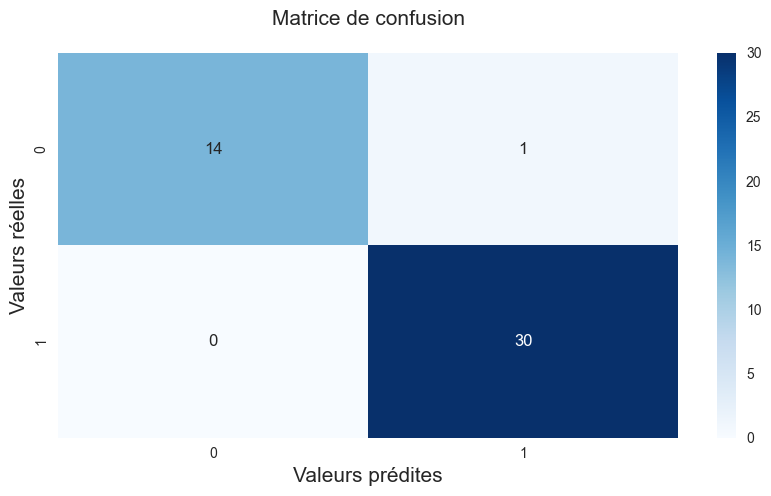

In [153]:
plot_crosstab(matrix, "Matrice de confusion")

 ⚠️ La matrice de confusion dépend du seuil de classification. Le seuil implicite vaut 50%.

#### Probabilité et seuil de classification
Dans un régression logistique, predict_proba() renvoie une probabilité des classes auxquelles appartient l'instance.<br>
Un tableau 2 dimensions est retourné avec le pourcentage de probabilité d'être classifié 0 pour la 1re colonne, et 1 pour la seconde.

In [154]:
probas_pred=model_reg_log.predict_proba(X_test)
pd.DataFrame(np.round(probas_pred,4), index=X_test.index)

,0,1
427,0.0479,0.9521
904,0.0225,0.9775
1329,0.8312,0.1688
610,0.1322,0.8678
1284,0.9933,0.0067
481,0.0040,0.9960
1190,0.2057,0.7943
1080,0.9805,0.0195
461,0.0376,0.9624
1088,0.9993,0.0007


Je créé un dataframe pour y stocker, pour chaque seuil testé, le score associé, ce qui va me permettre d'identifier le score (et donc le seuil) le plus efficace pour ce jeu de test.<br>


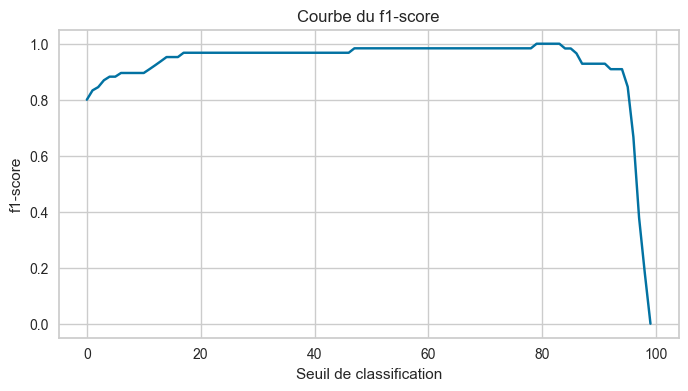

,f1-score,seuil
0,0.800000,0
1,0.833333,1
2,0.845070,2
3,0.869565,3
4,0.882353,4
...,...,...
95,0.846154,95
96,0.666667,96
97,0.378378,97
98,0.181818,98


In [155]:
threshold_array = np.linspace(0, 1, 100) # On va tester chaque pourcentage de 1 à 100 (np.arange ne fonctionne pas
#threshold_array = np.arange(0, 1, 0.01 )
f1_results=pd.DataFrame(columns=["f1-score","seuil"])

# Labels (1 ou 0) prédits pour un seuil donné allant de 0 à 100%
for threshold in threshold_array:
    label_pred_threshold = (probas_pred[:,1] > threshold).astype(int) # astype(int) permet de basculer le résultat en 1 / 0 plutôt que True/False
    # Calcul de la matrice de confusion pour un seuil donné
    matrix_threshold = metrics.confusion_matrix(y_true=y_test, y_pred=label_pred_threshold)
    scores = metrics.f1_score(y_test,label_pred_threshold)
    # store results
    f1_results=pd.concat([f1_results,pd.DataFrame.from_records([{"f1-score":scores,"seuil":int(threshold*100)}])],ignore_index=True)

plt.figure(figsize=(8,4))
plt.plot(f1_results["f1-score"])
plt.xlabel("Seuil de classification")
plt.ylabel("f1-score")
plt.title("Courbe du f1-score")
plt.show()
f1_results

J'identifie les seuils ayant obtenus le meilleur scrore f1.

In [156]:
best_class_threshold=max(f1_results["f1-score"])
best_threshold=f1_results.seuil[f1_results["f1-score"]==best_class_threshold]

print (f'''Le(s) meilleur(s) seuil(s) est(sont) : {best_threshold.values}''')

Le(s) meilleur(s) seuil(s) est(sont) : [79 80 81 82 83]


Je relance ma matrice de confusion en fixant le seuil.

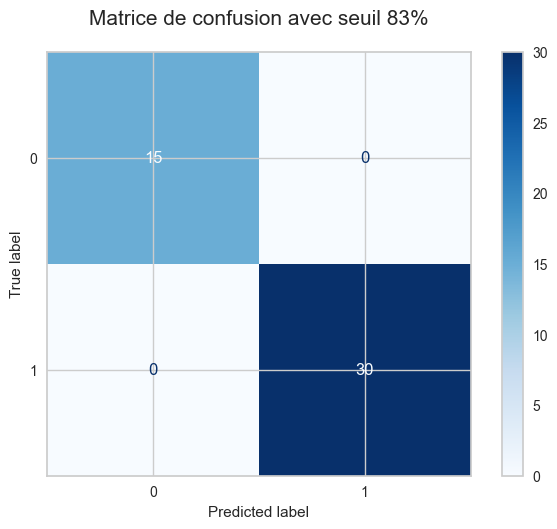

In [157]:
# Définition d'un seuil de classification 
threshold = max(best_threshold)/100

# Labels prédits pour un seuil donné
label_pred_threshold = (probas_pred[:,1] > threshold).astype(int)

# Affichage de la matrice de confusion pour un seuil donné
ConfusionMatrixDisplay.from_predictions(y_test,label_pred_threshold,cmap="Blues")
plt.title (f"Matrice de confusion avec seuil {threshold:.0%}", pad=20, fontsize=15)
plt.show()

Pour ce jeu de test, nous avons défini le meilleur seuil de classification.<br>
C'est  un peu l'équivalent de ce que fait la courbe ROC. On peut l'ajuster en fonction de ce qu'on souhaite : maximiser le rappel ou la précision.<br>
C'est le contexte qui va permettre de choisir.


#### Courbe de ROC
La courbe ROC (Receiver Operating Characteristic) représente la sensibilité en fonction de la spécificité pour différents seuils de décision. <br>
L'aire sous la courbe ROC, l'AUC (Area Under the (ROC) Curve ), est une mesure de la qualité de la classification qui varie entre 0.5 dans pour une classification aléatoire et 1 dans le meilleur des cas.

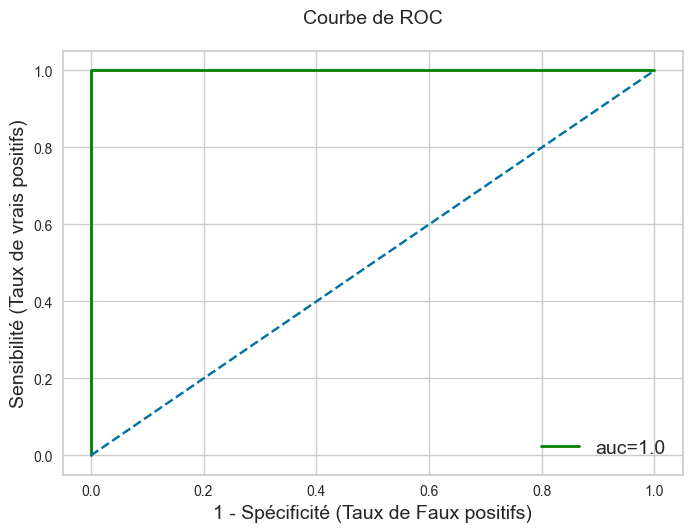

Notre aire sous la courbe (AUC) vaut 1.0.


In [158]:
#Récupération de la prédiction de la valeur positive
#y_pred_proba = lr.predict_proba(X_test)[:,1] 

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, probas_pred[:,1])
auc = metrics.auc(false_positive_rate, true_positive_rate)

plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, linestyle="-", label=f"auc={np.round(auc,4)}")
plt.plot([0, 1], [0, 1], linestyle='--') # Tracé de la droite classifieur aléatoire
plt.xlabel('1 - Spécificité (Taux de Faux positifs)', fontsize=14)
plt.ylabel('Sensibilité (Taux de vrais positifs)', fontsize=14)
plt.title('Courbe de ROC',fontsize=14, pad=20)
plt.legend(fontsize=14)
plt.show()
print(f"Notre aire sous la courbe (AUC) vaut {auc}.")
#print(pd.DataFrame(thresholds))

#### Courbe Precision/Recall

Prédiction des valeurs et des probabilités de test_y en fonction du modèle de régression logistique ajusté (fit)

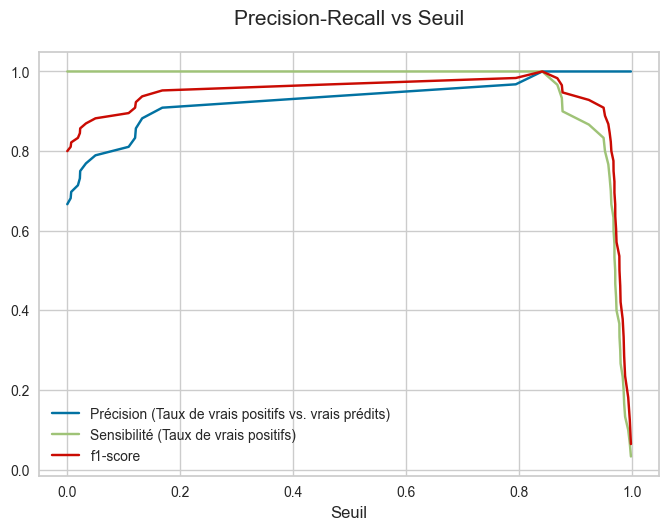

0.9999999999999999.


In [159]:
# Retrieve probability of being 1 (in second column of probas_pred)
precision, recall, threshold = precision_recall_curve(y_test, probas_pred[:,1]) 

# Putting results in a dataframe (minus last line for precision and recall to have the same number of lines than threshold)
df = pd.DataFrame(dict(precision=precision[:-1], recall=recall[:-1],threshold=threshold))

# Adding the f1 score (kind of mean between precision and recall)
df['f1-score']=2 * (df.precision * df.recall) / (df.precision + df.recall)

pr_auc = metrics.auc(recall, precision)

df.plot(x="threshold", y=["precision","recall","f1-score"], label=["Précision (Taux de vrais positifs vs. vrais prédits)","Sensibilité (Taux de vrais positifs)",'f1-score'])


#ax=df.plot(x="threshold", y=["precision","recall"], label=["Précision (Taux de vrais positifs vs. vrais prédits)","r"])
#ax = dfpr.plot(x="threshold", y=['precision', 'recall', 'F1'], figsize=(4, 4))

plt.title("Precision-Recall vs Seuil", pad=20,fontsize=15)
plt.xlabel("Seuil", fontsize=12)
plt.legend(loc="lower left")
#plt.xlim([0,1])
plt.show()
print(f"{pr_auc}.")


In [160]:
higher_score=max(df["f1-score"])
df[df["f1-score"]==higher_score]

,precision,recall,threshold,f1-score
15,1.0,1.0,0.841107,1.0


<u>**Observation**</u><br>
On n'a pas besoin d'optimiser selon un seuil, entre 0.40 et 0.8 c'est très bien. Par défaut, le seuil vaut 0.5.

#### Courbe d'apprentissage

Nombre de données d'entraînement : [18 37 56 75 94]


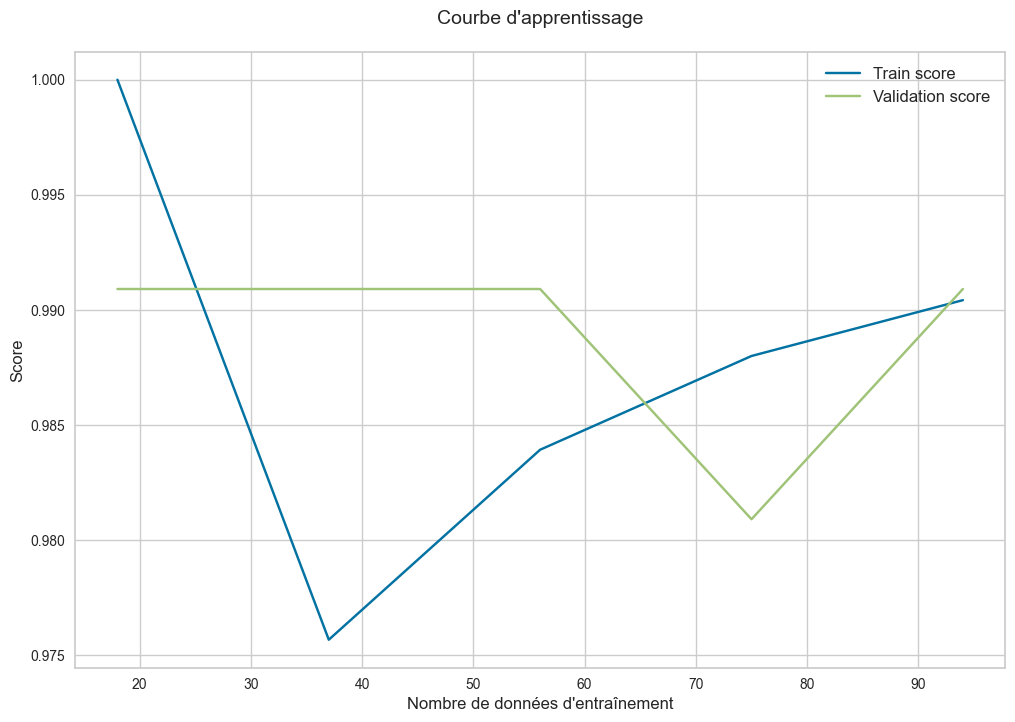

In [161]:
N, train_score, val_score,  = learning_curve(model_reg_log, X_train, y_train, cv=10, train_sizes=np.linspace(0.2, 1, 5)) # 5 lots de 20 à 100%

print ("Nombre de données d'entraînement :" ,N)

plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='Train score')
plt.plot(N, val_score.mean(axis=1), label='Validation score')
plt.title("Courbe d'apprentissage",pad=20, size=14) 
plt.xlabel("Nombre de données d'entraînement",fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.legend(fontsize=12)
plt.show()

<u>**Observation**</u><br>
La courbe d'apprentissage a déjà de très bon scores, l'axe y est très resséré. Plus de données n'aideraient pas à améliorer le modèle.

## Clustering
Je vais commencer par regrouper mes variables via une ACP

### Analyse en Composantes Principales (PCA)

Pour rappel, la valeur propre associée à un axe correspond à la fraction d’inertie qu’il retranscrit. Plus elle  est  élevée,  plus  le  facteur  est  important  dans  la  lecture  des  résultats. L’enjeu  justement  est  de 
déceler à partir de quel stade l’information restituée peut être considérée négligeable. En tenant compte de plusieurs  éléments  
- le  nombre d’observations «n»
- le  nombre de  variables  «p» de l’analyse
- le  ratio  «n:p» entre  le  nombre d’observations et le nombre de variables
- le  degré  de  liaison  (la  corrélation)  entre  les  variables
- l’existence éventuelle de blocs de variables corrélées dans le tableau de données.

Le ratio  «n:p»  est  particulièrement  important,  il  détermine  la  stabilité  des  résultats.  Certaines références affirment qu’une ACP n’est vraiment viable que s’il est supérieur à 3.

➡️ Nous avons 1500/6 = 250 dans notre fichier. Nous pouvons travailler en confiance sur l'ACP.

L'ACP permet donc de trouver les directions selon lesquelles la Variance de données est maximale pour perdre le moins d'informations possible quand on les projette.

On va afficher la table des valeurs propres de nos données (indiquant pour chacun des composantes, la valeur propre, le pourcentage de variance expliqué par la composante (taux d'inertie) et le pourcentage cumulé de variance expliquée pour nous aider à choisit le nombre de composantes.

<u>Quelques méthodes pour choisir le nombre de composantes principales à conserver</u> :

1. **La qualité de représentation du nuage de points** Comme le nombre de CP est égal au nombre de variables d'origine, il ne faut retenir que les CP qui expliquent le plus la variance (70-95%) pour faciliter l'interprétation. Plus les CP conservées expliquent la majorité des variations dans les données d'origine, meilleur sera le modèle PCA. Ceci est hautement subjectif et basé sur l'interprétation de l'utilisateur.=> <u>Méthode à ne pas utiliser seule.</u>

2. **Le critère de Kayser** : Dans une ACP normée, la somme des valeurs propres étant égale  au  nombre  de  variables,leur moyenne vaut 1.  Nous  considérons par  conséquent qu’un axe est intéressant si sa valeur propre est supérieure à 1. Généralement, les CP avec des valeurs propres> 1 contribuent à une plus grande variance et doivent être conservés pour une analyse plus approfondie.<br>
On peut aussi le calculer ainsi : on a tendance à ne pas considérer comme importants les axes dont l’inertie associée est inférieure à (100/p)% , car ils représentent moins de variabilité qu’une seule variable initiale. La valeur de (100/p)% est celle obtenue quand toutes les variables sont indépendantes deux à deux. => <u>Méthode à ne pas utiliser, en tout cas pas seule.</u>

3. **La règle de Règle de Karlis – Saporta - Spinaki.** On pense  généralement que le seuil de 1 est trop permissif. Une règle plus restrictive consiste à le définir comme suit: <br>
➡️ moyenne des valeurs propres  +  2  fois  leur  écart-type. 

Nous serons d’autant plus exigeants (enclins à accepter moins de facteurs) que le nombre de variables «p» est élevé par rapport aux observations disponibles «n».<br>
Formule : 1+2(racine carrée de p-1/n-1)<br>

4. **Le Scree plot ou l'éboulis des valeurs propres  ou scree-test ou test d'accumulation** est une autre technique graphique utile dans la rétention des CP qui consiste à regarder comment évoluent les valeurs propres en fonction de leur ordre d'extraction. Le terme « scree » fait référence à l'accumulation de dépôts rocheux au pied d'une montagne créant ainsi un petit promontoire à l'endroit où le dénivelé de la montagne se transforme en une pente plus douce. On ne retient justement que les composantes qui précédent le passage à cette pente douce, donc au niveau du changement brusque.


Je commence par standardiser les données

Calcul de l'ACP avec la librairie fanalysis, plus simple pour gérer les graphiques liés à l'ACP (comme le cercle de corrélation).<br>
Je passe la paramètre std_unit à True pour normaliser mes données, ce qui m'évite de le faire avant.

In [162]:
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns, index=X.index)
X_scaled

,diagonal,height_left,height_right,margin_low,margin_up,length
1116,1.075373,-0.294220,0.597125,0.737748,1.168931,-1.659892
1368,-0.940951,1.155025,1.382021,1.699268,0.426665,-0.446945
422,-1.337605,-1.570935,-0.882103,-0.646258,-0.727970,0.094759
413,1.207591,-1.122359,-1.274551,-0.617121,0.096769,0.318506
451,0.777882,-0.673784,-1.153798,-0.602553,-1.470236,0.412716
...,...,...,...,...,...,...
1312,-0.048480,1.327554,0.385807,0.679474,-0.398074,-2.437120
694,-1.469823,-0.742795,-0.972668,-0.689963,-0.191889,0.318506
1001,-0.048480,-0.432243,1.140515,0.694043,-0.026941,-1.636340
322,-0.610406,0.499414,-0.036830,-0.354888,-0.686733,0.766001


In [163]:
fanalysis_PCA = pca.PCA
n_components=X_scaled.shape[1]

model_pca = fanalysis_PCA(std_unit=False, row_labels=X_scaled.index.values, col_labels=X_scaled.columns.values, n_components=n_components)
model_pca.fit(X_scaled.to_numpy())

pd.DataFrame(model_pca.eig_,index=["Valeur propre","% Variance expliquée","% Var. cumulée expliquée"])

,0,1,2,3,4,5
Valeur propre,2.659258,1.006921,0.847534,0.589361,0.508629,0.388297
% Variance expliquée,44.320970,16.782020,14.125563,9.822683,8.477143,6.471621
% Var. cumulée expliquée,44.320970,61.102991,75.228553,85.051236,93.528379,100.000000


**Observation**<br>
*Le critère de Kayser* prend en compte les composantes dont la valeur propre est supérieure à 1 ➡️ ici, les 2 premières.<br>
L'autre méthode de calcul confirme cette observation, avec  la formule nombre d'observations / nombre de variables : 100/6 = 16.67 ➡️ les 2 premières composantes ont une inertie associée supérieure à ce nombre.

La *règle de Karlis – Saporta - Spinaki* viendrait indiquer que la première composante suffirait puisque le résultat de la formule est supérieur à la valeur propre de la 2de composante :<br>
Formule : 1+2(racine carrée de p-1/n-1)<br>
    Dans notre cas : <br>
        1+2(√(6-1)/(1500-1))<br>
        1+2(√0.003)<br>
        =1.12<br>
Mais nous n'allons pas en tenir compte et garder les 2 premières composantes.
_____________

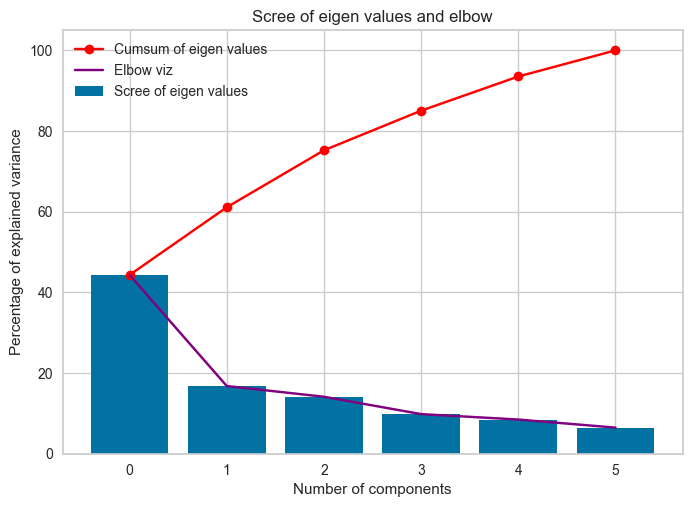

In [164]:
#ratio_var= pca.explained_variance_ratio_*100 # Pourcentage de variance cumulé expliqué par les n premières composantes.
plt.bar(np.arange(len(model_pca.eig_[1])), model_pca.eig_[1], label="Scree of eigen values")
plt.plot(np.arange(len(model_pca.eig_[1])), model_pca.eig_[2],c="red",marker='o', label="Cumsum of eigen values")
plt.plot(np.arange(len(model_pca.eig_[1])), model_pca.eig_[1],c="purple",marker='_', label="Elbow viz")

plt.xlabel("Number of components")
plt.ylabel("Percentage of explained variance",)
plt.title("Scree of eigen values and elbow")
plt.xticks(range(len(model_pca.eig_[1])))
plt.legend()
plt.show()

**Observation**<br>
L'ébouli des valeurs propores indique 2 composantes également.
____________


In [165]:
eigen_vector=pd.DataFrame(model_pca.eigen_vectors_)
eigen_vector

,0,1,2,3,4,5
0,-0.094952,0.938979,-0.310439,0.039786,-0.100811,0.034417
1,0.306380,0.337218,0.820182,-0.247968,0.239333,0.030802
2,0.430299,-0.023709,-0.462265,-0.544748,0.524238,-0.170343
3,0.502959,-0.053096,-0.110132,-0.163115,-0.451762,0.708088
4,0.453245,0.029665,-0.070643,0.778572,0.412359,0.111733
5,-0.503546,-0.018474,-0.011039,-0.086013,0.532543,0.674520


**Observation**<br>
Ce tableau de composantes n'est pas ordonné comme il faut contrairement à eigen_vectors de la librairie scikit-learn. Les lignes et les colonnes sont inverséses.<br>
(voir projet 9) 

Je transpose le résultat.
_____________________

In [166]:
eigen_vector=eigen_vector.transpose()
eigen_vector

,0,1,2,3,4,5
0,-0.094952,0.306380,0.430299,0.502959,0.453245,-0.503546
1,0.938979,0.337218,-0.023709,-0.053096,0.029665,-0.018474
2,-0.310439,0.820182,-0.462265,-0.110132,-0.070643,-0.011039
3,0.039786,-0.247968,-0.544748,-0.163115,0.778572,-0.086013
4,-0.100811,0.239333,0.524238,-0.451762,0.412359,0.532543
5,0.034417,0.030802,-0.170343,0.708088,0.111733,0.674520


Je vérifie que les variables sont bien décorrélées (même si je n'avais pas vérifié avant)

In [167]:
X_projected=model_pca.transform(X_scaled)

comp1=X_projected.iloc[:,0]
comp2=X_projected.iloc[:,1]
coef_corr_comp, p_value_comp = stats.pearsonr(comp1, comp2) # paramétrique
coef_corr_comp1, p_value_comp1 = stats.spearmanr(comp1, comp2) # non paramétrique
print("Coefficients Pearson :",coef_corr_comp, p_value_comp)
print("Coefficients Spearman :",coef_corr_comp1, p_value_comp1)


Coefficients Pearson : 1.3097162243624894e-16 0.999999999999989
Coefficients Spearman : -0.00400906706964754 0.9611661173358719


**Observation**<br>
Il n'y a pas de corrélation linéaires entre les 2 composantes, le coefficient de corrélation est proche de 0 et une p-value étant bien supérieur au seuil de rejet de 0.05 dans les 2 tests (paramétrique et non paramétrique), ce qui signifie qu'on accèpte l'hypothèse nulle (les variables sont indépendantes).<br>
L'ACP transforme un jeu de variables en un nouvel ensemble de variables non corrélées.
_____________________

Affichage de :
- cercle de corrélation regroupant les 2 1res composantes
- tableaux de contribution des 2 variables du 1er plan factoriel. 

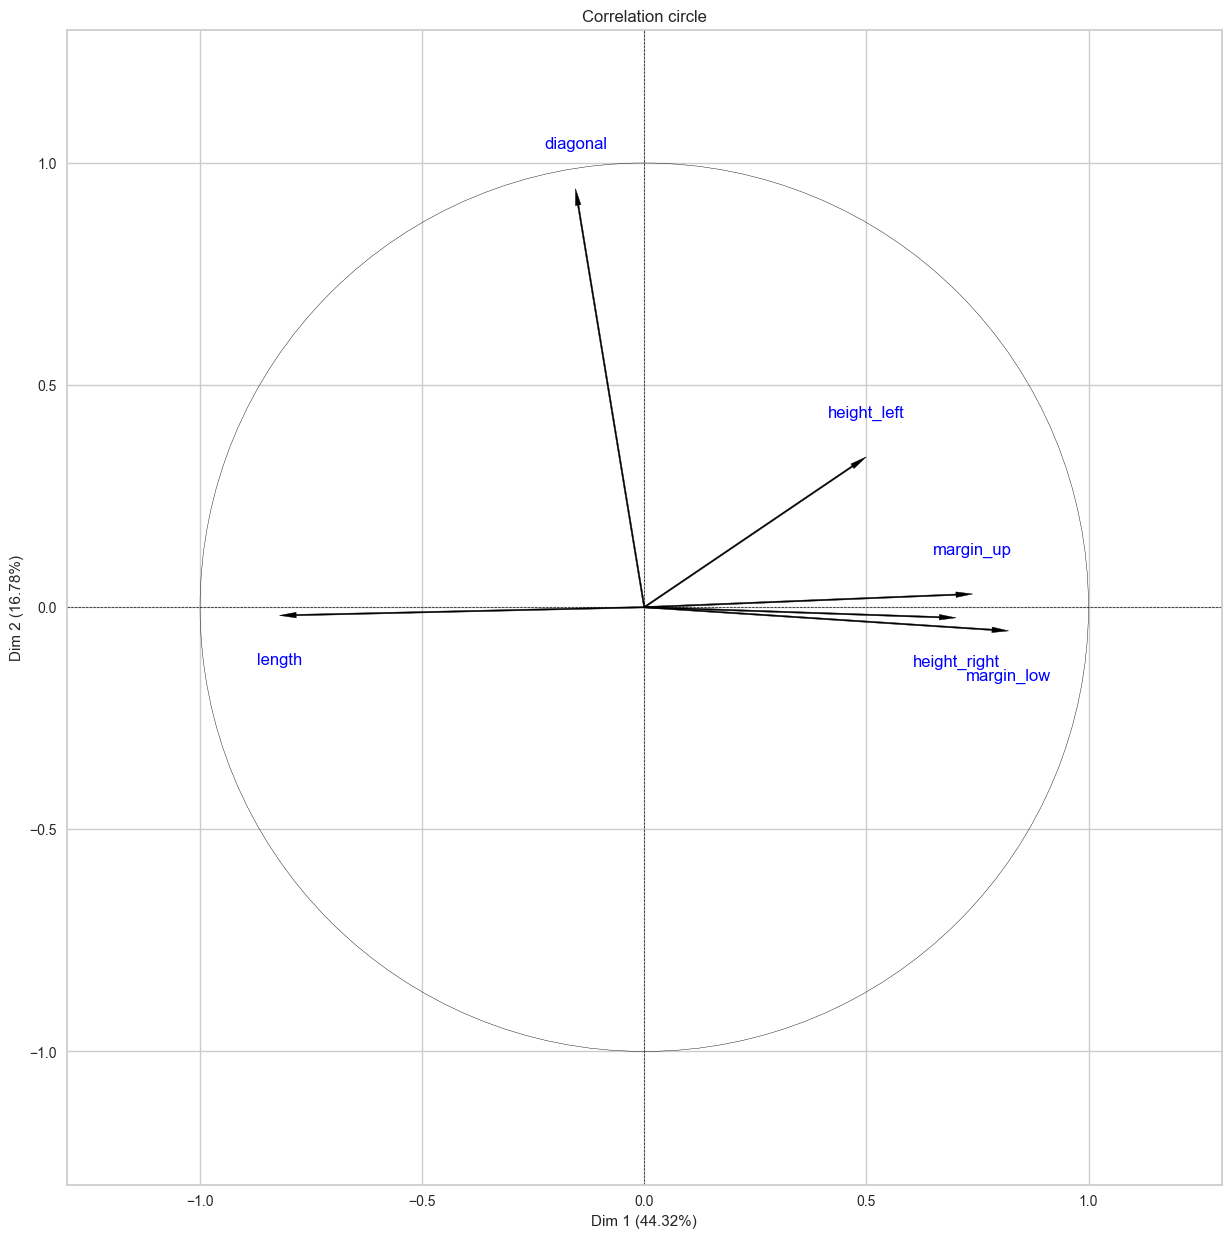

/Users/laetitia/opt/anaconda3/lib/python3.9/site-packages/fanalysis/base.py:602: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  labels = pd.Series(col_labels)[np.argsort(contribs)][limit:n_cols]


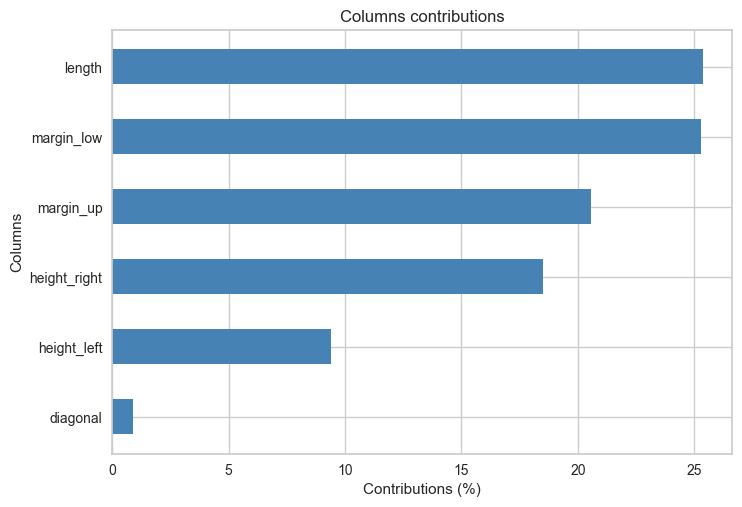

/Users/laetitia/opt/anaconda3/lib/python3.9/site-packages/fanalysis/base.py:602: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  labels = pd.Series(col_labels)[np.argsort(contribs)][limit:n_cols]


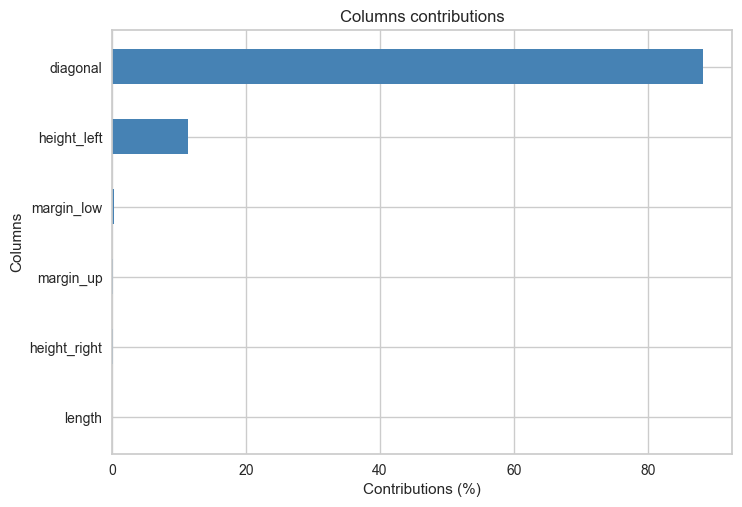

In [168]:
model_pca.correlation_circle(num_x_axis=1, num_y_axis=2,figsize=(15,15))
model_pca.plot_col_contrib(1,n_components)
model_pca.plot_col_contrib(2,n_components)

**Observation**<br>

Les axes factoriels sont des axes virtuels issus d’une synthèse entre les variables de l’analyse. Ils n’ont pas nécessairement un sens précis même si on peut souvent leur trouver un sens en s’aidant notamment de la représentation des variable sur le cercle de corrélation.<br>
- Les points les plus intéressants sont ceux qui sont assez proches d’un des axes, et assez loin de l’origine : *lenght, margin_low, margin_up* et *diagonal* qui sont très bien représentés sur le mapping.
- *Diagonal* et *lenght* sont les variables les mieux représentés sur le mapping car la plus proche du cercle de corrélation, elles contribuent chacune le plus à leur axe, positivement pour *lenght* sur l'axe 1 et négativement pour *diagonal* sur l'axe 2.<br>
- La variable *height_left* est celle qui a le moins d'influence.
- L’angle plutôt fermé (en partant de l’origine) que forment les points *margin_up* et *margin_low* indique une corrélation entre ces 2 variables.<br>
- Ces dernières contribuent également très fortement et négativement à l'axe 1.<br>
- En revanche, l’angle quasi droit formé par *lenght* et *diagonal* indique que ces deux variables sont indépendantes entre elles.
- La longueur du billet est anticorrélée aux autres dimensions du billet, hauteur et marges.

**L'axe 2 renseignerait sur la diagonale du billet et l'axe 1 sur les autres mesures.**

_______________________

### Clustering (K-means) sur ACP
On fait le clustering sur les variables initiales et pas synthétiques. Il ne faut pas centrer et réduire pour ne pas éliminer l'importance entre les axes, on ne veut pas donner autant d'importance à chaque dimension.<br>

In [169]:
X_projected.iloc[:,0:2]

,0,1
1116,1.801393,0.922548
1368,2.311009,-0.596115
422,-1.436570,-1.753848
413,-1.433879,0.815394
451,-1.954031,0.511313
...,...,...
1312,1.965877,0.390142
694,-1.100933,-1.582498
1001,1.523772,-0.225743
322,-0.680348,-0.419554


In [170]:
X_projected=model_pca.transform(X_scaled.to_numpy())
X_projected=pd.DataFrame(X_projected,columns=["F"+str(i+1) for i in range (n_components)], index=X.index)
print("Coordonnées des coefficients de corrélation des individus")
X_projected.iloc[:,:2]

Coordonnées des coefficients de corrélation des individus


,F1,F2
1116,1.801393,0.922548
1368,2.311009,-0.596115
422,-1.436570,-1.753848
413,-1.433879,0.815394
451,-1.954031,0.511313
...,...,...
1312,1.965877,0.390142
694,-1.100933,-1.582498
1001,1.523772,-0.225743
322,-0.680348,-0.419554


Afin de pouvoir comparer la régression logisique avec les kmeans, je vais créer 2 clusters. <br>
Mais dans l'absolu, le k-means a pour objectif de séparer les données en groupes homogènes ayant des caractéristiques communes. Et pourraient révéler, par exemple, un groupe de vrai billets, un groupe de faux billets, et un groupe proches des vrais billets mais qui sont faux.<br>
Je regarde tout de même ce que les méthodes du coude et du score de silhouette préconisent comme nombre de cluster.

#### Recherche du nombre de clusters : Méthode du coude

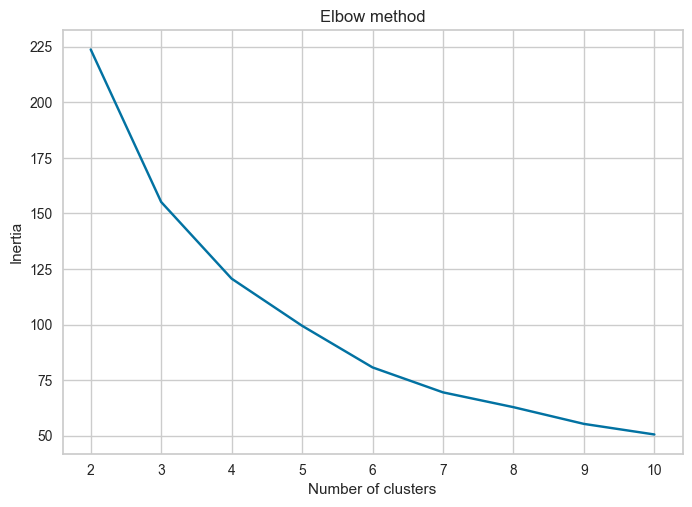

In [171]:
inertias =[]
for i in range(2, 11):
    model_kmeans = KMeans(n_clusters = i, random_state=42).fit(X_projected.iloc[:,:2])
    #kmeans.fit(X_projected)
    inertias.append(model_kmeans.inertia_)

plt.plot(range(2, 11), inertias)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

#### Recherche du nombre de clusters : Méthode de l'analyse du coefficient de silhouette

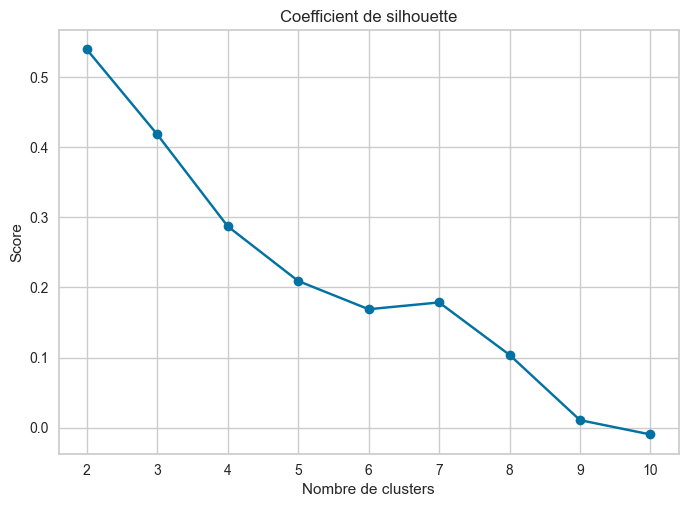

In [172]:
#Use silhouette score
silhouettes=[]
for n_clusters in range(2,11):
    model_kmeans2 = KMeans(n_clusters=n_clusters,n_init=10, init='k-means++',random_state=0) # Instantiate the Kmeans model with 10 times a random init
    model_kmeans2.fit(X_projected) # Fit the KMeans model on normalized data
    score = silhouette_score(X_projected.iloc[:,0:2], model_kmeans2.labels_, metric='euclidean') #Calculate Silhoutte coefficient Score 
    silhouettes.append(score)
    
    #print(f"Quand le nombre de clusters vaut {n_clusters}, le score de silhouette vaut {score:.3f}.")  

plt.plot(range(2,11),silhouettes, marker='o') 
plt.title("Coefficient de silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score")
plt.show()

**Observation**<br>
Les coefficients sont proches de 0 et indiquent un nombre de 2 clusters.<br>
Rappel : le coefficient peut varier entre -1 et +1. Un coefficient proche de +1 signifie que l’observation est située bien à l’intérieur de son propre cluster, tandis qu’un coefficient proche de 0 signifie qu’elle se situe près d’une frontière ; enfin, un coefficient proche de -1 signifie que l’observation est associée au mauvais cluster. 

Pour la méthode du coude, il n'y a pas de données franches, on pourrait partir sur 2 ou 3.<br>
______________

### Prédiction

Je construis mon modèle sur 2 clusters et je lance la prédiction

In [173]:
model_kmeans = KMeans(n_clusters = 2, random_state=42)
model_kmeans.fit(X_scaled)

# Stockage de l'information contenant le cluster :
y_pred = model_kmeans.predict(X_scaled)
# ou
clusters_km = model_kmeans.labels_
clusters_km

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int32)

In [174]:
y_pred

array([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1], dtype=int32)

In [175]:
X_projected.iloc[:,[0,1]]

,F1,F2
1116,1.801393,0.922548
1368,2.311009,-0.596115
422,-1.436570,-1.753848
413,-1.433879,0.815394
451,-1.954031,0.511313
...,...,...
1312,1.965877,0.390142
694,-1.100933,-1.582498
1001,1.523772,-0.225743
322,-0.680348,-0.419554


In [176]:
final_df=pd.concat([banknotes,X_projected.iloc[:,[0,1]],pd.DataFrame(clusters_km, index=X_projected.index, columns=["cluster"])], axis=1)
final_df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,cluster
1116,False,172.26,103.90,104.12,4.99,3.42,111.27,1.801393,0.922548,0
1368,False,171.65,104.32,104.38,5.65,3.24,112.30,2.311009,-0.596115,0
422,True,171.53,103.53,103.63,4.04,2.96,112.76,-1.436570,-1.753848,1
413,True,172.30,103.66,103.50,4.06,3.16,112.95,-1.433879,0.815394,1
451,True,172.17,103.79,103.54,4.07,2.78,113.03,-1.954031,0.511313,1
...,...,...,...,...,...,...,...,...,...,...
1312,False,171.92,104.37,104.05,4.95,3.04,110.61,1.965877,0.390142,0
694,True,171.49,103.77,103.60,4.01,3.09,112.95,-1.100933,-1.582498,1
1001,False,171.92,103.86,104.30,4.96,3.13,111.29,1.523772,-0.225743,0
322,True,171.75,104.13,103.91,4.24,2.97,113.33,-0.680348,-0.419554,1


In [177]:
#final_df.cluster=np.where(final_df.cluster==1,0,1)

In [178]:
final_df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,F1,F2,cluster
1116,False,172.26,103.90,104.12,4.99,3.42,111.27,1.801393,0.922548,0
1368,False,171.65,104.32,104.38,5.65,3.24,112.30,2.311009,-0.596115,0
422,True,171.53,103.53,103.63,4.04,2.96,112.76,-1.436570,-1.753848,1
413,True,172.30,103.66,103.50,4.06,3.16,112.95,-1.433879,0.815394,1
451,True,172.17,103.79,103.54,4.07,2.78,113.03,-1.954031,0.511313,1
...,...,...,...,...,...,...,...,...,...,...
1312,False,171.92,104.37,104.05,4.95,3.04,110.61,1.965877,0.390142,0
694,True,171.49,103.77,103.60,4.01,3.09,112.95,-1.100933,-1.582498,1
1001,False,171.92,103.86,104.30,4.96,3.13,111.29,1.523772,-0.225743,0
322,True,171.75,104.13,103.91,4.24,2.97,113.33,-0.680348,-0.419554,1


In [179]:
clusters_cendroids = model_kmeans.cluster_centers_
clusters_cendroids

array([[-0.1651428 ,  0.55760061,  0.76168096,  1.10253152,  0.89240045,
        -1.15397814],
       [ 0.08507356, -0.2872488 , -0.3923811 , -0.56797078, -0.45972144,
         0.59447359]])

Projection des individus et des centroïdes avec visualisation kmeans sur ACP

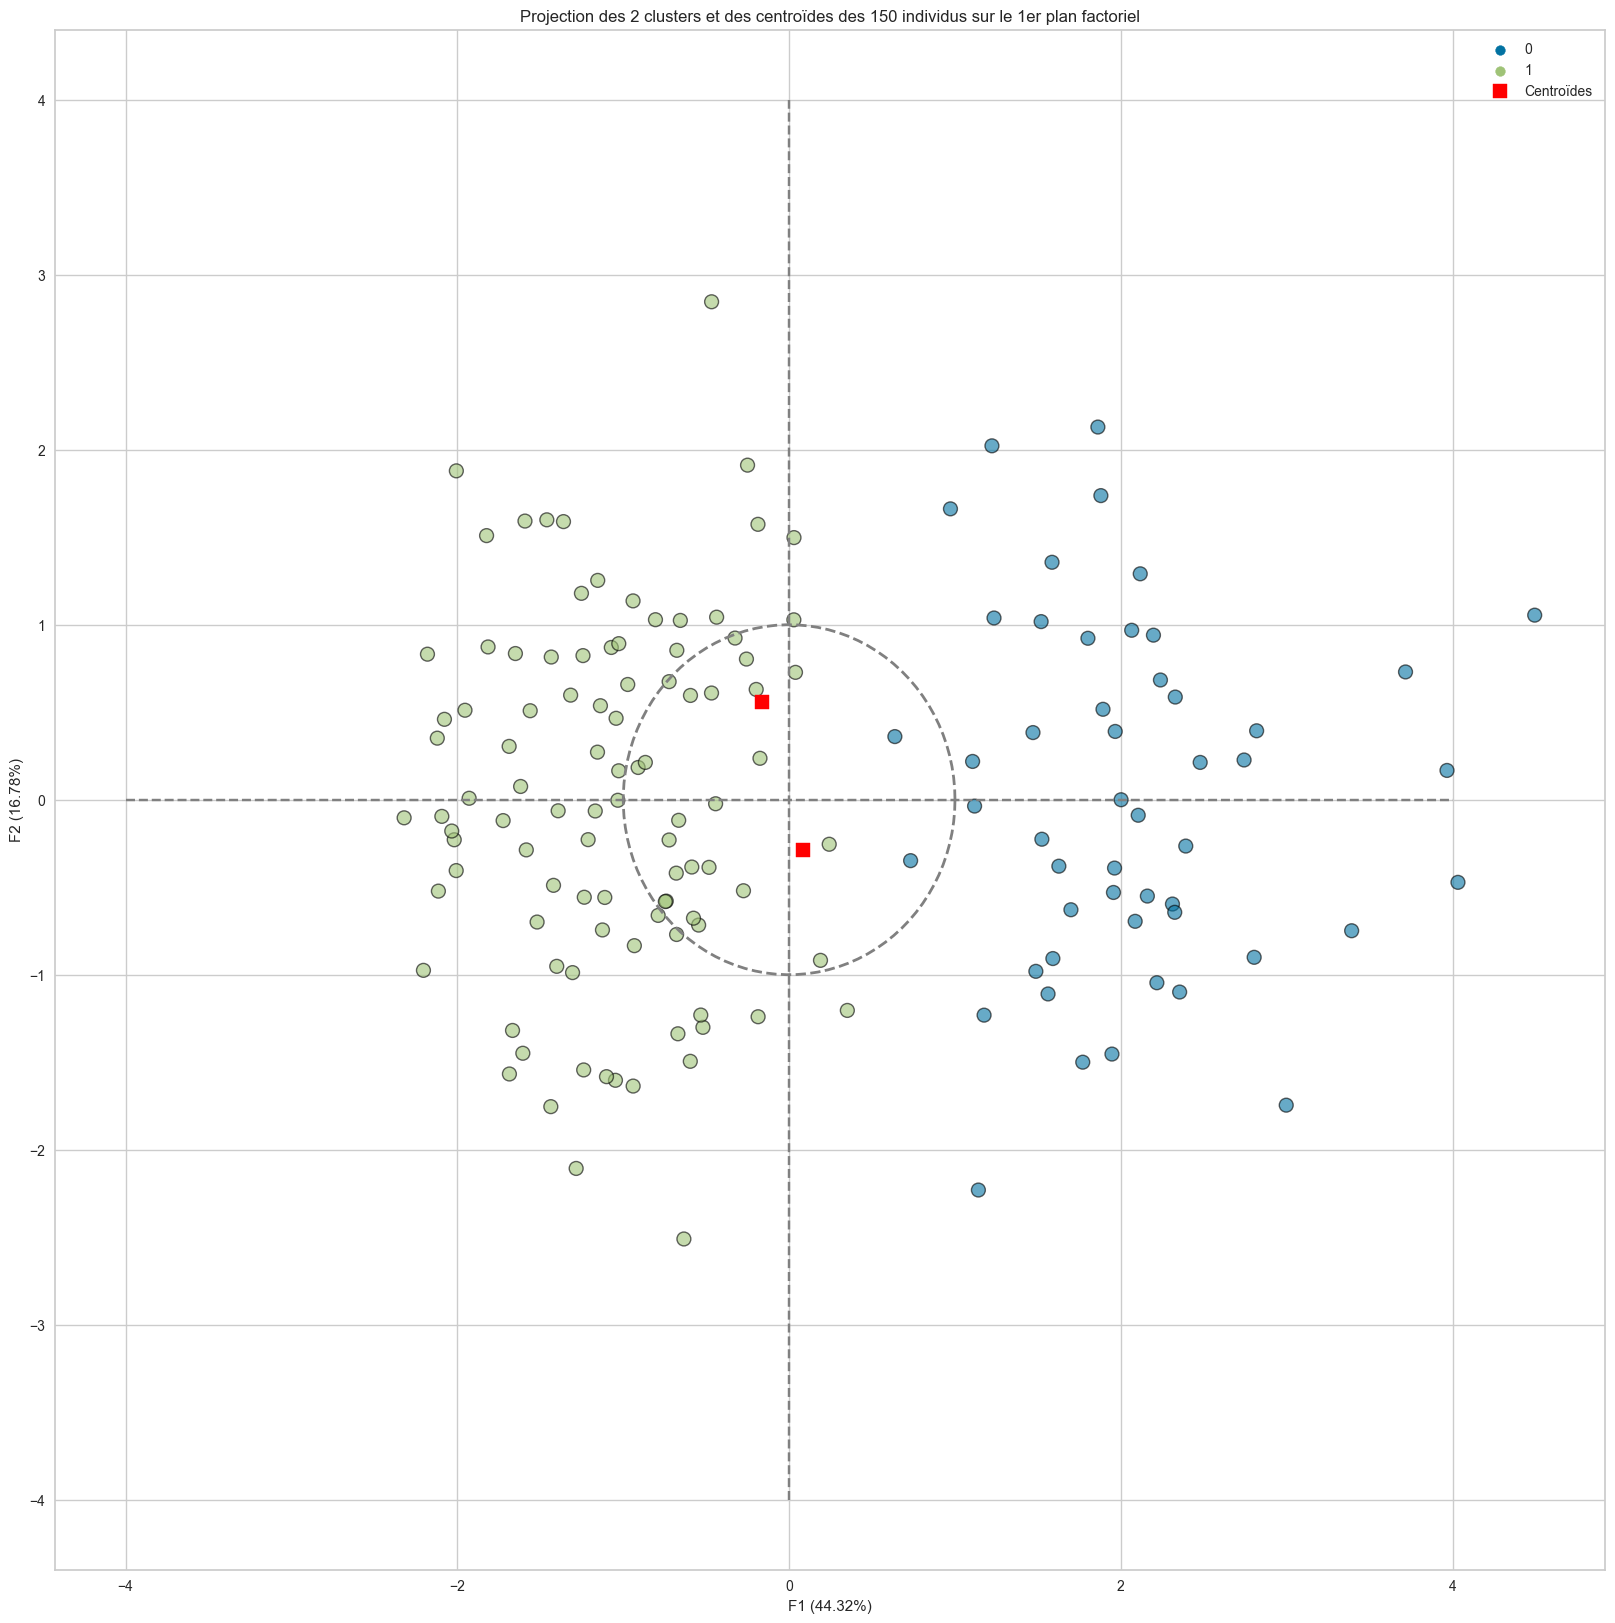

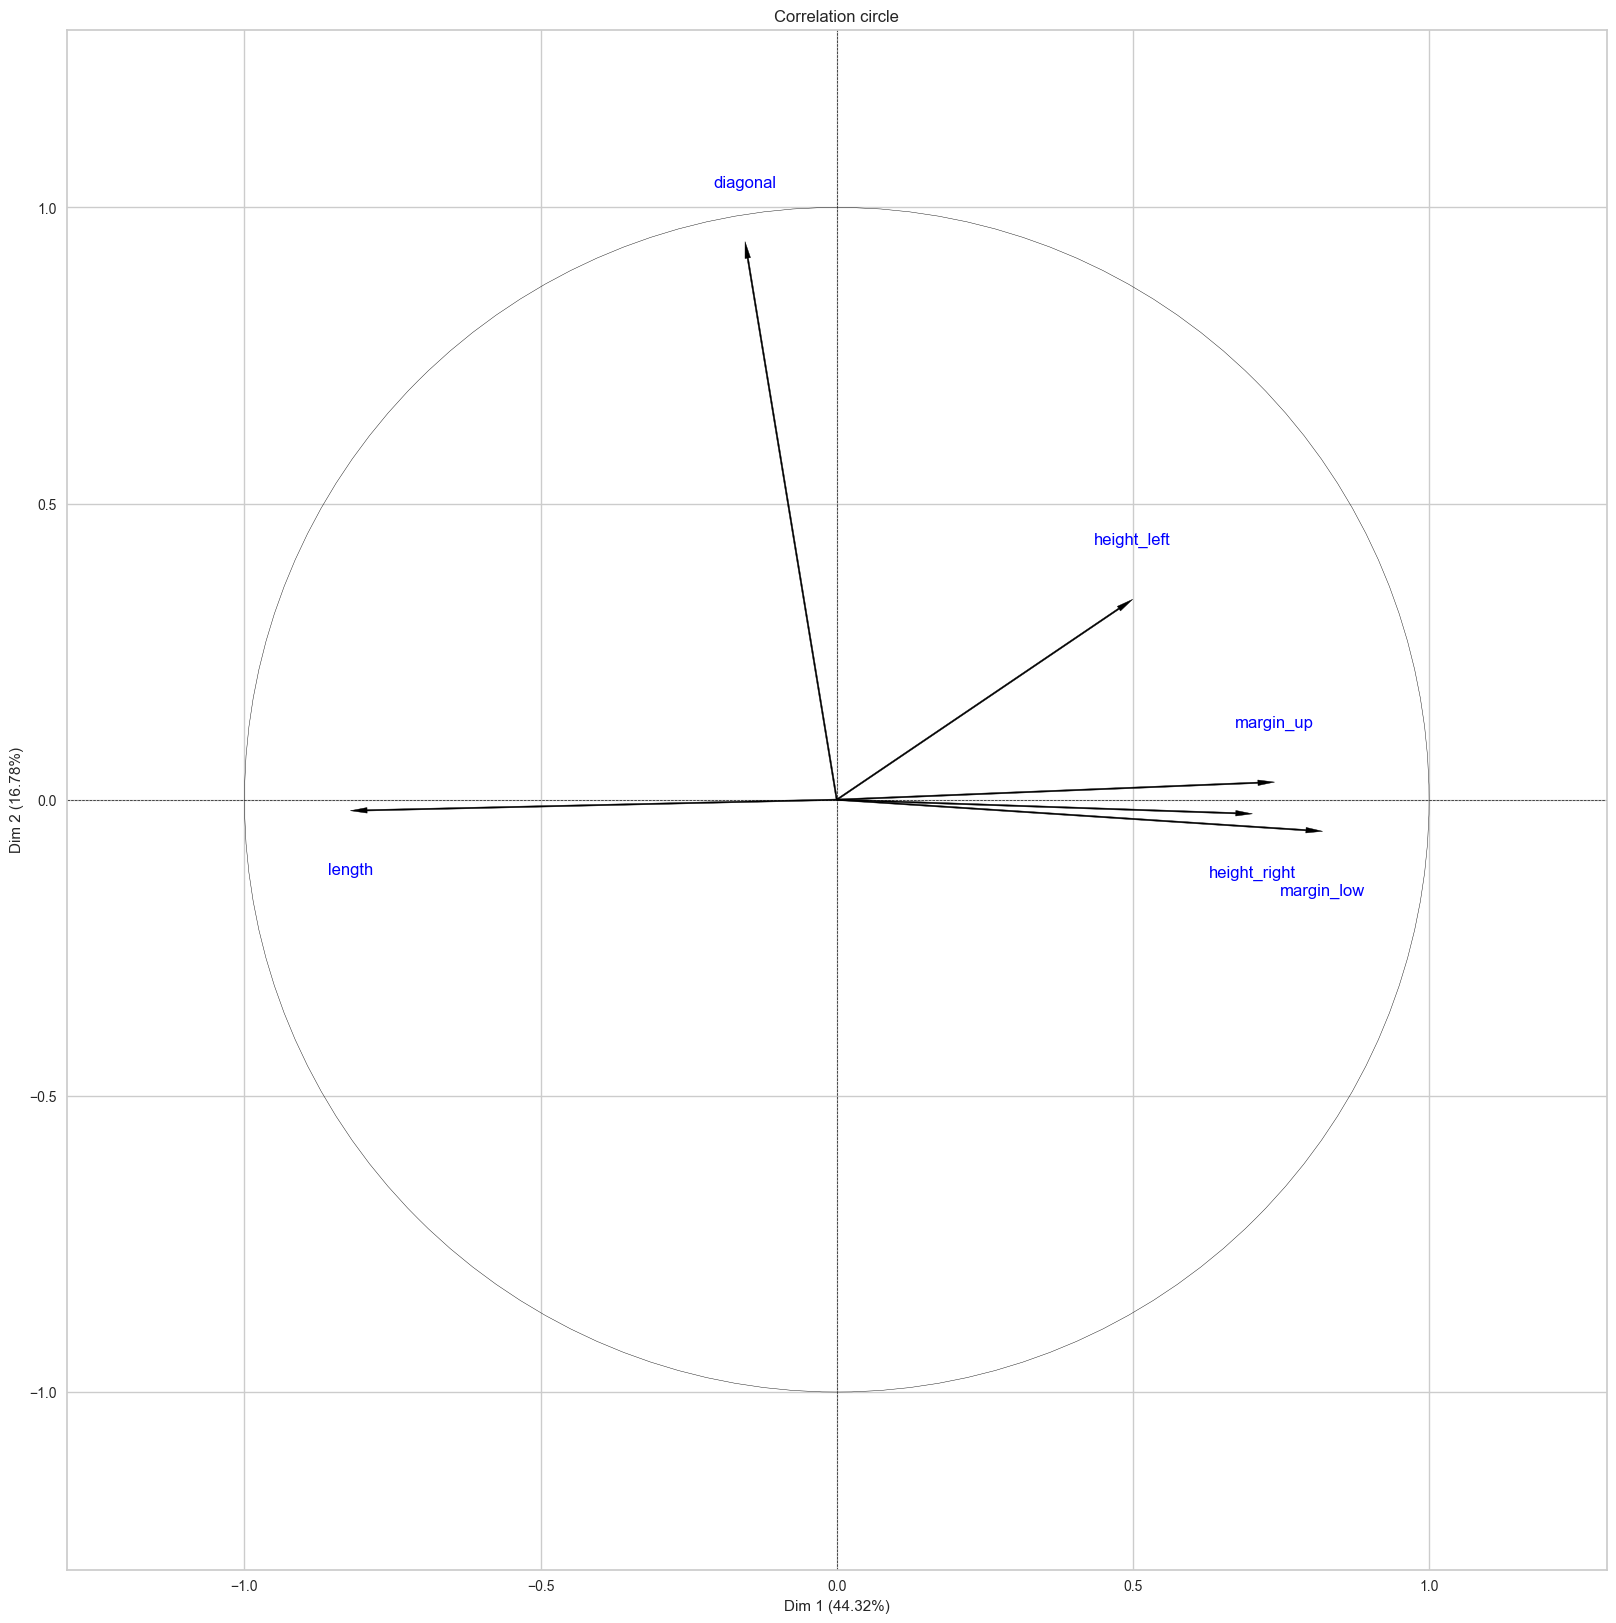

In [180]:
plt.figure(figsize=(20, 20))

kwargs  =   {'edgecolor':"black", # for edge color
             'linewidth':1, # line width of spot
             'linestyle':'-', # line style of spot
            }

sns.scatterplot(x=X_projected.iloc[:,0],y=X_projected.iloc[:,1], hue=final_df.cluster, alpha=0.6, **kwargs, s=100)
plt.scatter(clusters_cendroids[:,0], clusters_cendroids[:,1], marker='s', s=100, c='red', label="Centroïdes")

plt.legend()
draw_circle()
# affichage des lignes horizontales et verticales
plt.plot([-4, 4], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-4, 4], color='grey', ls='--')

plt.xlabel(f'F1 ({model_pca.eig_[1][0]:.2f}%)')
plt.ylabel(f'F2 ({model_pca.eig_[1][1]:.2f}%)')
plt.title(f"Projection des 2 clusters et des centroïdes des {X_projected.shape[0]} individus sur le 1er plan factoriel")

plt.show()

model_pca.correlation_circle(num_x_axis=1, num_y_axis=2,figsize=(20,20))

# Autre méthode avec matplotlib

#colors = ['red', 'blue','green']
#color_centroids=["black"]

#for k in [0,1]:
#    plt.scatter(final_df.F1[final_df.cluster==k],final_df.F2[final_df.cluster==k],c=colors[k],
#                edgecolors="black", linewidths=1.4, s=40, alpha=0.5,label=f"Cluster {k}")

#    plt.legend()
#    plt.scatter(clusters_cendroids[:,0], clusters_cendroids[:,1],edgecolors="black",s=100, marker="s",alpha=1,c="black", label="Centroïds")

#draw_circle()
# affichage des lignes horizontales et verticales
#plt.plot([-4, 4], [0, 0], color='grey', ls='--')
#plt.plot([0, 0], [-4, 4], color='grey', ls='--')

#plt.xlabel(f'F1 ({model_pca.eig_[1][0]:.2f}%)')
#plt.ylabel(f'F2 ({model_pca.eig_[1][1]:.2f}%)')
#plt.title(f"Projection des 2 clusters et des centroïdes des {X_projected.shape[0]} individus sur le 1er plan factoriel")
#plt.show()

<u>**Observation**</u><br>
La projection et le cercle de corrélation (regroupant les 2 1res composantes) nous indique que les vrais billets sont plus longs, et que les faux ont une tendance à avoir une hauteur et une marge plus petites.<br>
Les centroïdes sont bien représentatifs.

### Evaluation du modèle k-means

On utilise la matrice de confusion avec :
- La colonne *is_genuine* qui retourne la vraie valeur,
- La colonne cluster qui affiche la prédiction (le cluster)

In [181]:
final_df.is_genuine.value_counts()

True     99
False    51
Name: is_genuine, dtype: int64

In [182]:
matrix = pd.crosstab(final_df.is_genuine*1,final_df.cluster,colnames=['Prédictions'], rownames=['Observations'], margins=True)
matrix.columns = ['Prédiction_Faux_billets','Prédiction_Vrais_billets',"Total"]
matrix.index = ['Faux_billets','Vrais_billets',"Total"]
matrix

,Prédiction_Faux_billets,Prédiction_Vrais_billets,Total
Faux_billets,51,0,51
Vrais_billets,0,99,99
Total,51,99,150


Je crée mon dataframe sans margins pour représenter la répartition sous forme de heatmap.

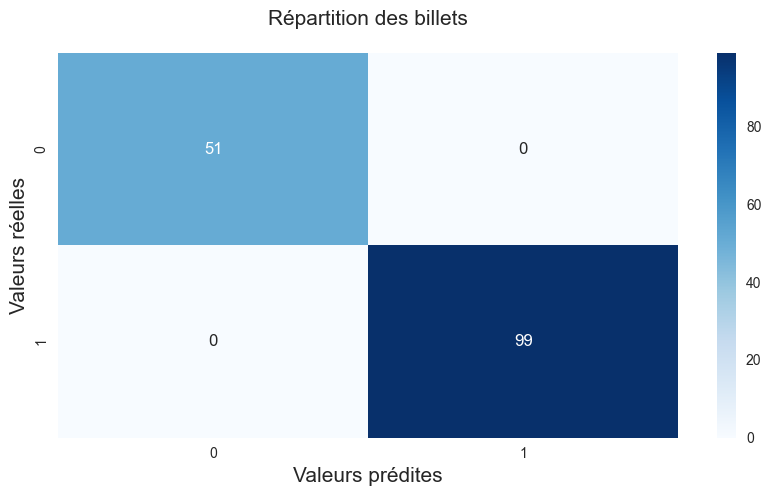

In [183]:
matrix = pd.crosstab(final_df.is_genuine*1,final_df.cluster)
plot_crosstab(matrix, "Répartition des billets")

Je calcule la performance de mon modèle avec :
 - Rappel (recall) = TP / (TP + FN)
 - Précision (precision) = TP / (TP + FP)
 - Spécificité (specificity) = TN / (FP + TN)
 - F−mesure = 2×(Précision×Rappel)/(Précision+Rappel)=2TP / (2TP + FP + FN)
 

Je créé mes tableaux de valeurs observées et valeurs prédites

In [184]:
TN = matrix[0][0]
FP = matrix[1][0]
FN = matrix[0][1]
TP = matrix[1][1]
#Ou comme ça
#y_true = np.array(final_df.is_genuine*1)
#y_pred = np.array(final_df.cluster)
#TN, FP, FN, TP = metrics.confusion_matrix(y_true, y_pred).ravel()

Je lance les mesures

In [185]:
recall = TP / (TP + FN) 
precision = TP / (TP + FP) 
specificity = TN / (FP + TN) 
f_mesure = 2*TP / (2*TP + FP + FN) 
accuracy = (TP + TN) / (TP + TN + FP + FN) 

print(f'''Le nombre de vrais positifs vaut : {TP}
Le nombre de vrais négatifs vaut : {TN}
Le nombre de faux positifs vaut : {FP}
Le nombre de faux négatifs vaut : {FN}

On peut maintenant calculer les mesures de performances : 
recall = {recall:.2%}
precision = {precision:.2%}
accuracy = {accuracy:.2%}
specificity = {specificity:.2%}
f_mesure = {f_mesure:.2%}

''')

Le nombre de vrais positifs vaut : 99
Le nombre de vrais négatifs vaut : 51
Le nombre de faux positifs vaut : 0
Le nombre de faux négatifs vaut : 0

On peut maintenant calculer les mesures de performances : 
recall = 100.00%
precision = 100.00%
accuracy = 100.00%
specificity = 100.00%
f_mesure = 100.00%




In [186]:
kmeans_model_evaluation = pd.DataFrame(data=[precision,recall,accuracy,specificity,f_mesure], index=["precision","recall","accuracy","specificity","f_mesure"], columns=["measures_kmeans"])
kmeans_model_evaluation=round(kmeans_model_evaluation*100,2)
kmeans_model_evaluation

,measures_kmeans
precision,100.0
recall,100.0
accuracy,100.0
specificity,100.0
f_mesure,100.0


## Choix du modèle de prédiction

Je concatène mes 2 dataframes de mesures pour comparer les résultats.

In [187]:
comparison_model_evaluation = pd.concat([log_reg_model_evaluation, kmeans_model_evaluation],axis=1)
comparison_model_evaluation

,measures_log_reg,measures_kmeans
precision,96.77,100.0
recall,100.00,100.0
accuracy,97.78,100.0
specificity,93.33,100.0
f_mesure,98.36,100.0


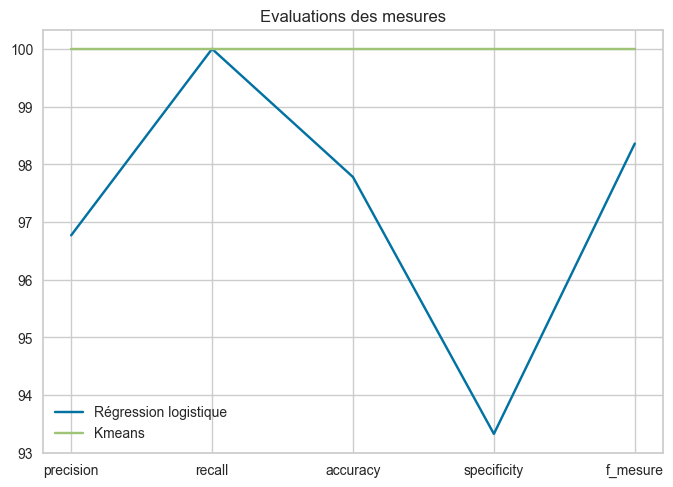

In [188]:
plt.plot(comparison_model_evaluation.loc[:,"measures_log_reg"], label="Régression logistique")
plt.plot(comparison_model_evaluation.loc[:,"measures_kmeans"], label='Kmeans')
plt.title("Evaluations des mesures")
plt.legend()

plt.show()

In [189]:
comparison_model_evaluation["best_measure"]=""
comparison_model_evaluation["difference"]=""
for i in range (comparison_model_evaluation.shape[0]):
    col1 = comparison_model_evaluation.iloc[i,0]
    col2 = comparison_model_evaluation.iloc[i,1]
    if col1 >= col2:
        comparison_model_evaluation.iloc[i,2]="log_reg"
        comparison_model_evaluation.iloc[i,3]=col1-col2
    else:
        comparison_model_evaluation.iloc[i,2]="kmeans"
        comparison_model_evaluation.iloc[i,3]=col2-col1

In [190]:
comparison_model_evaluation

,measures_log_reg,measures_kmeans,best_measure,difference
precision,96.77,100.0,kmeans,3.23
recall,100.00,100.0,log_reg,0.0
accuracy,97.78,100.0,kmeans,2.22
specificity,93.33,100.0,kmeans,6.67
f_mesure,98.36,100.0,kmeans,1.64


**Les 2 modèles donnent de très bons résultats. Mais le Kmeans n'est pas une méthode de prédiction même si notre échantillon est sensible au clustering.<br>
On se dirigera donc plutôt vers la régression logistique qui est un modèle prédictif qui va apprendre au fur et à mesure de l'injection de nouvelles données.**

# V. IDENTIFICATION VRAIS/FAUX BILLETS

## Jeu de données

In [191]:
try :
    input_file = input("Saisir le chemin d'accès au fichier : ")
    prod_banknotes = pd.read_csv(input_file, sep=",")
    prod_banknotes
except Exception as err :
    print(f"""Erreur lors du chargement du fichier ⚠️ {err}""")   

Saisir le chemin d'accès au fichier :  /Users/laetitia/Documents/Formations/2022 - Data analyst/OCR/Projet 10 - Détectez de faux billets/Code/files/billets_production.csv


Je ne conserve que les données numériques

In [192]:
prod_banknotes.iloc[:,:-1]

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.76,104.01,103.54,5.21,3.30,111.42
1,171.87,104.17,104.13,6.00,3.31,112.09
2,172.00,104.58,104.29,4.99,3.39,111.57
3,172.49,104.55,104.34,4.44,3.03,113.20
4,171.65,103.63,103.56,3.77,3.16,113.33


## Prédiction avec régression logistique

In [193]:
prod_banknotes.iloc[:,:-1].values

array([[171.76, 104.01, 103.54,   5.21,   3.3 , 111.42],
       [171.87, 104.17, 104.13,   6.  ,   3.31, 112.09],
       [172.  , 104.58, 104.29,   4.99,   3.39, 111.57],
       [172.49, 104.55, 104.34,   4.44,   3.03, 113.2 ],
       [171.65, 103.63, 103.56,   3.77,   3.16, 113.33]])

In [194]:
y_pred=model_reg_log.predict(prod_banknotes.iloc[:,:-1])
y_pred

array([0, 0, 0, 1, 1])

## Probabilités

In [195]:
y_proba=pd.DataFrame(model_reg_log.predict_proba(prod_banknotes.iloc[:,:-1]), columns=["prob_false (%)","prob_true (%)"])
y_proba=round(y_proba*100,2)
y_proba

,prob_false (%),prob_true (%)
0,94.51,5.49
1,98.31,1.69
2,96.77,3.23
3,18.05,81.95
4,0.72,99.28


<u>**Observation**</u><br>
Le seuil de probabilité est supérieur à 82% dans le pire des cas, il y a de fortes chances que nos prédictions soient bonnes.

## Consolidation résultat final

On ajoute les résultats (prédiction et pourcentage) au fichier en entrée.

In [196]:
prod_banknotes=pd.concat([prod_banknotes,y_proba], axis=1)
prod_banknotes["is_genuine"]=np.where(y_pred==0,"False","True")
prod_banknotes

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prob_false (%),prob_true (%),is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,94.51,5.49,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,98.31,1.69,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,96.77,3.23,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,18.05,81.95,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,0.72,99.28,True


## "Bonus" - Prédiction avec kmeans

In [197]:
try :
    input_file = input("Saisir le chemin d'accès au fichier : ")
    prod_banknotes = pd.read_csv(input_file, sep=",")
    prod_banknotes
except Exception as err :
    print(f"""Erreur lors du chargement du fichier ⚠️ {err}""")   

Saisir le chemin d'accès au fichier :  /Users/laetitia/Documents/Formations/2022 - Data analyst/OCR/Projet 10 - Détectez de faux billets/Code/files/billets_production.csv


In [198]:
prod_banknotes.iloc[:,:-1].values

array([[171.76, 104.01, 103.54,   5.21,   3.3 , 111.42],
       [171.87, 104.17, 104.13,   6.  ,   3.31, 112.09],
       [172.  , 104.58, 104.29,   4.99,   3.39, 111.57],
       [172.49, 104.55, 104.34,   4.44,   3.03, 113.2 ],
       [171.65, 103.63, 103.56,   3.77,   3.16, 113.33]])

On applique la prédiction sur les données centrées réduites

In [199]:
prod_banknotes_df=scaler.fit_transform(prod_banknotes.iloc[:,:-1])
prod_banknotes_df = pd.DataFrame(prod_banknotes_df,columns=prod_banknotes.columns.difference(["id"]), index=prod_banknotes.index-1)
y_pred_km=model_kmeans.fit_predict(prod_banknotes_df.values)
y_pred_km

array([0, 0, 0, 1, 1], dtype=int32)

<u>**Observation**</u><br>
On ne connait pas les probabilités de prédiction avec kmeans.

## Consolidation résultat final

On ajoute les résultats (prédiction et pourcentage) au fichier en entrée.

In [200]:
prod_banknotes["is_genuine"]=np.where(y_pred==0,"False","True")
prod_banknotes

,diagonal,height_left,height_right,margin_low,margin_up,length,id,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True
